In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import sys
sys.path.append("/Users/gregoirelejay/dev/personal/tag_walk/tag_walk") 
# sys.path.append("/usr/local/lib/python2.7/site-packages")
print(sys.executable)
import fachung
import inferno.trainers

/usr/local/opt/python3/bin/python3.6


In [3]:
import torchvision.transforms as transforms
from fachung.datasets.tagwalk import TagwalkDataset

# BASE_DATA = '/Volumes/bobby/tag_walk/tag_walk/data/tag_walk/'
BASE_DATA = '../data/tag_walk/'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

DEFAULT_TRANSFORMS = (
    transforms.Compose([
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Scale((224, 224)),
        transforms.ToTensor(),
        normalize
    ])
)

tw_dataset = TagwalkDataset(
    csv_path=BASE_DATA + 'assocs.csv',
    img_path=BASE_DATA + 'images/all',
    transform=DEFAULT_TRANSFORMS
)

In [4]:
print(tw_dataset.num_classes)
tw_dataset[0][0].shape

655


torch.Size([3, 224, 224])

In [5]:
from fachung.datasets.tagwalk import tagwalk_dataloader
tw_dataloader = tagwalk_dataloader(tw_dataset)

In [6]:
tw_dataset[0][1].shape

torch.Size([655])

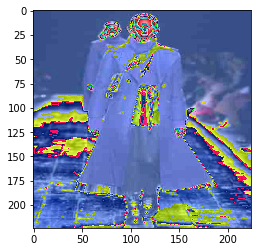

In [7]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

to_pl = transforms.ToPILImage()
plt.imshow(to_pl(tw_dataset[0][0]))

In [8]:
import torchvision
import torch.nn as nn
model = torchvision.models.resnet18(pretrained=True)
num_classes = tw_dataset.num_classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [9]:
num_classes

655

In [10]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [11]:
from fachung.utils import get_train_valid_test_loaders
train, val, test = get_train_valid_test_loaders(tw_dataset, 4, 42)

Dataset sizes:
    Train:      (19516,)
    Validation: (4879,)
    Test:       (4879,)


In [12]:
from inferno.trainers.basic import Trainer
from inferno.trainers.callbacks.logging.tensorboard import TensorboardLogger

trainer = (
    Trainer(model)
    .build_criterion('MultiLabelSoftMarginLoss')
    .build_metric('CategoricalError')
    .build_optimizer('Adam')
    .validate_every((1, 'epochs'))
    .save_every((1, 'epochs'))
    .save_to_directory('../data/trainer_logs')
    .set_max_num_epochs(2)
    .build_logger(TensorboardLogger(log_scalars_every=(1, 'iteration'),
                                    log_images_every='never'),
                  log_directory='../data/tf_logging')
)

In [62]:
(
    trainer
    .bind_loader('train', train)
    .bind_loader('validate', val)
)

trainer.fit()

[+][2017-09-02 08:55:47.724639] Training iteration 0 (batch 0 of epoch 0).
[+][2017-09-02 08:55:49.066447] Training iteration 1 (batch 1 of epoch 0).
[+][2017-09-02 08:55:50.127861] Training iteration 2 (batch 2 of epoch 0).
[+][2017-09-02 08:55:51.183199] Training iteration 3 (batch 3 of epoch 0).
[+][2017-09-02 08:55:52.358607] Training iteration 4 (batch 4 of epoch 0).
[+][2017-09-02 08:55:53.456387] Training iteration 5 (batch 5 of epoch 0).
[+][2017-09-02 08:55:54.588463] Training iteration 6 (batch 6 of epoch 0).
[+][2017-09-02 08:55:55.595989] Training iteration 7 (batch 7 of epoch 0).
[+][2017-09-02 08:55:56.641137] Training iteration 8 (batch 8 of epoch 0).
[+][2017-09-02 08:55:57.803042] Training iteration 9 (batch 9 of epoch 0).
[+][2017-09-02 08:55:58.880726] Training iteration 10 (batch 10 of epoch 0).
[+][2017-09-02 08:55:59.885303] Training iteration 11 (batch 11 of epoch 0).
[+][2017-09-02 08:56:00.978875] Training iteration 12 (batch 12 of epoch 0).
[+][2017-09-02 08:5

[+][2017-09-02 08:57:45.998694] Training iteration 107 (batch 107 of epoch 0).
[+][2017-09-02 08:57:47.117293] Training iteration 108 (batch 108 of epoch 0).
[+][2017-09-02 08:57:48.177359] Training iteration 109 (batch 109 of epoch 0).
[+][2017-09-02 08:57:49.199912] Training iteration 110 (batch 110 of epoch 0).
[+][2017-09-02 08:57:50.214204] Training iteration 111 (batch 111 of epoch 0).
[+][2017-09-02 08:57:51.240347] Training iteration 112 (batch 112 of epoch 0).
[+][2017-09-02 08:57:52.231599] Training iteration 113 (batch 113 of epoch 0).
[+][2017-09-02 08:57:53.258985] Training iteration 114 (batch 114 of epoch 0).
[+][2017-09-02 08:57:54.334439] Training iteration 115 (batch 115 of epoch 0).
[+][2017-09-02 08:57:55.354870] Training iteration 116 (batch 116 of epoch 0).
[+][2017-09-02 08:57:56.343991] Training iteration 117 (batch 117 of epoch 0).
[+][2017-09-02 08:57:57.388129] Training iteration 118 (batch 118 of epoch 0).
[+][2017-09-02 08:57:58.438755] Training iteration 1

[+][2017-09-02 08:59:40.638683] Training iteration 211 (batch 211 of epoch 0).
[+][2017-09-02 08:59:41.672301] Training iteration 212 (batch 212 of epoch 0).
[+][2017-09-02 08:59:42.661838] Training iteration 213 (batch 213 of epoch 0).
[+][2017-09-02 08:59:43.686010] Training iteration 214 (batch 214 of epoch 0).
[+][2017-09-02 08:59:44.683674] Training iteration 215 (batch 215 of epoch 0).
[+][2017-09-02 08:59:45.680457] Training iteration 216 (batch 216 of epoch 0).
[+][2017-09-02 08:59:46.746351] Training iteration 217 (batch 217 of epoch 0).
[+][2017-09-02 08:59:47.710351] Training iteration 218 (batch 218 of epoch 0).
[+][2017-09-02 08:59:48.724609] Training iteration 219 (batch 219 of epoch 0).
[+][2017-09-02 08:59:49.778015] Training iteration 220 (batch 220 of epoch 0).
[+][2017-09-02 08:59:50.761974] Training iteration 221 (batch 221 of epoch 0).
[+][2017-09-02 08:59:51.774290] Training iteration 222 (batch 222 of epoch 0).
[+][2017-09-02 08:59:52.737820] Training iteration 2

[+][2017-09-02 09:01:27.583847] Training iteration 315 (batch 315 of epoch 0).
[+][2017-09-02 09:01:28.604875] Training iteration 316 (batch 316 of epoch 0).
[+][2017-09-02 09:01:29.548130] Training iteration 317 (batch 317 of epoch 0).
[+][2017-09-02 09:01:30.797452] Training iteration 318 (batch 318 of epoch 0).
[+][2017-09-02 09:01:31.891054] Training iteration 319 (batch 319 of epoch 0).
[+][2017-09-02 09:01:32.860102] Training iteration 320 (batch 320 of epoch 0).
[+][2017-09-02 09:01:33.978396] Training iteration 321 (batch 321 of epoch 0).
[+][2017-09-02 09:01:35.070046] Training iteration 322 (batch 322 of epoch 0).
[+][2017-09-02 09:01:36.237053] Training iteration 323 (batch 323 of epoch 0).
[+][2017-09-02 09:01:37.293801] Training iteration 324 (batch 324 of epoch 0).
[+][2017-09-02 09:01:38.302922] Training iteration 325 (batch 325 of epoch 0).
[+][2017-09-02 09:01:39.302781] Training iteration 326 (batch 326 of epoch 0).
[+][2017-09-02 09:01:40.316433] Training iteration 3

[+][2017-09-02 09:03:21.221466] Training iteration 419 (batch 419 of epoch 0).
[+][2017-09-02 09:03:22.388741] Training iteration 420 (batch 420 of epoch 0).
[+][2017-09-02 09:03:23.474054] Training iteration 421 (batch 421 of epoch 0).
[+][2017-09-02 09:03:24.607360] Training iteration 422 (batch 422 of epoch 0).
[+][2017-09-02 09:03:25.728532] Training iteration 423 (batch 423 of epoch 0).
[+][2017-09-02 09:03:26.867203] Training iteration 424 (batch 424 of epoch 0).
[+][2017-09-02 09:03:28.021767] Training iteration 425 (batch 425 of epoch 0).
[+][2017-09-02 09:03:29.108116] Training iteration 426 (batch 426 of epoch 0).
[+][2017-09-02 09:03:30.236671] Training iteration 427 (batch 427 of epoch 0).
[+][2017-09-02 09:03:31.736352] Training iteration 428 (batch 428 of epoch 0).
[+][2017-09-02 09:03:32.885405] Training iteration 429 (batch 429 of epoch 0).
[+][2017-09-02 09:03:34.447030] Training iteration 430 (batch 430 of epoch 0).
[+][2017-09-02 09:03:35.916852] Training iteration 4

[+][2017-09-02 09:05:16.921402] Training iteration 523 (batch 523 of epoch 0).
[+][2017-09-02 09:05:17.934882] Training iteration 524 (batch 524 of epoch 0).
[+][2017-09-02 09:05:18.966568] Training iteration 525 (batch 525 of epoch 0).
[+][2017-09-02 09:05:19.998426] Training iteration 526 (batch 526 of epoch 0).
[+][2017-09-02 09:05:21.040288] Training iteration 527 (batch 527 of epoch 0).
[+][2017-09-02 09:05:22.028736] Training iteration 528 (batch 528 of epoch 0).
[+][2017-09-02 09:05:23.086385] Training iteration 529 (batch 529 of epoch 0).
[+][2017-09-02 09:05:24.078505] Training iteration 530 (batch 530 of epoch 0).
[+][2017-09-02 09:05:25.128616] Training iteration 531 (batch 531 of epoch 0).
[+][2017-09-02 09:05:26.126662] Training iteration 532 (batch 532 of epoch 0).
[+][2017-09-02 09:05:27.185721] Training iteration 533 (batch 533 of epoch 0).
[+][2017-09-02 09:05:28.164858] Training iteration 534 (batch 534 of epoch 0).
[+][2017-09-02 09:05:29.236864] Training iteration 5

[+][2017-09-02 09:07:04.870287] Training iteration 627 (batch 627 of epoch 0).
[+][2017-09-02 09:07:05.922572] Training iteration 628 (batch 628 of epoch 0).
[+][2017-09-02 09:07:06.967622] Training iteration 629 (batch 629 of epoch 0).
[+][2017-09-02 09:07:07.963586] Training iteration 630 (batch 630 of epoch 0).
[+][2017-09-02 09:07:09.000635] Training iteration 631 (batch 631 of epoch 0).
[+][2017-09-02 09:07:10.171618] Training iteration 632 (batch 632 of epoch 0).
[+][2017-09-02 09:07:11.244717] Training iteration 633 (batch 633 of epoch 0).
[+][2017-09-02 09:07:12.260863] Training iteration 634 (batch 634 of epoch 0).
[+][2017-09-02 09:07:13.299154] Training iteration 635 (batch 635 of epoch 0).
[+][2017-09-02 09:07:14.357651] Training iteration 636 (batch 636 of epoch 0).
[+][2017-09-02 09:07:15.433692] Training iteration 637 (batch 637 of epoch 0).
[+][2017-09-02 09:07:16.458631] Training iteration 638 (batch 638 of epoch 0).
[+][2017-09-02 09:07:17.519973] Training iteration 6

[+][2017-09-02 09:08:55.648496] Training iteration 731 (batch 731 of epoch 0).
[+][2017-09-02 09:08:56.780569] Training iteration 732 (batch 732 of epoch 0).
[+][2017-09-02 09:08:57.868823] Training iteration 733 (batch 733 of epoch 0).
[+][2017-09-02 09:08:58.971541] Training iteration 734 (batch 734 of epoch 0).
[+][2017-09-02 09:08:59.972145] Training iteration 735 (batch 735 of epoch 0).
[+][2017-09-02 09:09:01.073146] Training iteration 736 (batch 736 of epoch 0).
[+][2017-09-02 09:09:02.163744] Training iteration 737 (batch 737 of epoch 0).
[+][2017-09-02 09:09:03.268145] Training iteration 738 (batch 738 of epoch 0).
[+][2017-09-02 09:09:04.377681] Training iteration 739 (batch 739 of epoch 0).
[+][2017-09-02 09:09:05.469493] Training iteration 740 (batch 740 of epoch 0).
[+][2017-09-02 09:09:06.533481] Training iteration 741 (batch 741 of epoch 0).
[+][2017-09-02 09:09:07.625943] Training iteration 742 (batch 742 of epoch 0).
[+][2017-09-02 09:09:08.673362] Training iteration 7

[+][2017-09-02 09:10:47.746682] Training iteration 835 (batch 835 of epoch 0).
[+][2017-09-02 09:10:48.821393] Training iteration 836 (batch 836 of epoch 0).
[+][2017-09-02 09:10:49.886474] Training iteration 837 (batch 837 of epoch 0).
[+][2017-09-02 09:10:50.910856] Training iteration 838 (batch 838 of epoch 0).
[+][2017-09-02 09:10:52.003858] Training iteration 839 (batch 839 of epoch 0).
[+][2017-09-02 09:10:53.057361] Training iteration 840 (batch 840 of epoch 0).
[+][2017-09-02 09:10:54.110912] Training iteration 841 (batch 841 of epoch 0).
[+][2017-09-02 09:10:55.183974] Training iteration 842 (batch 842 of epoch 0).
[+][2017-09-02 09:10:56.219892] Training iteration 843 (batch 843 of epoch 0).
[+][2017-09-02 09:10:57.312152] Training iteration 844 (batch 844 of epoch 0).
[+][2017-09-02 09:10:58.401107] Training iteration 845 (batch 845 of epoch 0).
[+][2017-09-02 09:10:59.439394] Training iteration 846 (batch 846 of epoch 0).
[+][2017-09-02 09:11:00.518732] Training iteration 8

[+][2017-09-02 09:12:37.971900] Training iteration 939 (batch 939 of epoch 0).
[+][2017-09-02 09:12:39.063653] Training iteration 940 (batch 940 of epoch 0).
[+][2017-09-02 09:12:40.164620] Training iteration 941 (batch 941 of epoch 0).
[+][2017-09-02 09:12:41.185482] Training iteration 942 (batch 942 of epoch 0).
[+][2017-09-02 09:12:42.257157] Training iteration 943 (batch 943 of epoch 0).
[+][2017-09-02 09:12:43.360888] Training iteration 944 (batch 944 of epoch 0).
[+][2017-09-02 09:12:44.410711] Training iteration 945 (batch 945 of epoch 0).
[+][2017-09-02 09:12:45.393648] Training iteration 946 (batch 946 of epoch 0).
[+][2017-09-02 09:12:46.479910] Training iteration 947 (batch 947 of epoch 0).
[+][2017-09-02 09:12:47.468774] Training iteration 948 (batch 948 of epoch 0).
[+][2017-09-02 09:12:48.531419] Training iteration 949 (batch 949 of epoch 0).
[+][2017-09-02 09:12:49.617378] Training iteration 950 (batch 950 of epoch 0).
[+][2017-09-02 09:12:50.697630] Training iteration 9

[+][2017-09-02 09:14:27.720496] Training iteration 1042 (batch 1042 of epoch 0).
[+][2017-09-02 09:14:28.810554] Training iteration 1043 (batch 1043 of epoch 0).
[+][2017-09-02 09:14:29.856104] Training iteration 1044 (batch 1044 of epoch 0).
[+][2017-09-02 09:14:30.981736] Training iteration 1045 (batch 1045 of epoch 0).
[+][2017-09-02 09:14:32.034345] Training iteration 1046 (batch 1046 of epoch 0).
[+][2017-09-02 09:14:33.039531] Training iteration 1047 (batch 1047 of epoch 0).
[+][2017-09-02 09:14:34.163918] Training iteration 1048 (batch 1048 of epoch 0).
[+][2017-09-02 09:14:35.268616] Training iteration 1049 (batch 1049 of epoch 0).
[+][2017-09-02 09:14:36.329307] Training iteration 1050 (batch 1050 of epoch 0).
[+][2017-09-02 09:14:37.401321] Training iteration 1051 (batch 1051 of epoch 0).
[+][2017-09-02 09:14:38.467270] Training iteration 1052 (batch 1052 of epoch 0).
[+][2017-09-02 09:14:39.537663] Training iteration 1053 (batch 1053 of epoch 0).
[+][2017-09-02 09:14:40.6414

[+][2017-09-02 09:16:16.386844] Training iteration 1144 (batch 1144 of epoch 0).
[+][2017-09-02 09:16:17.496273] Training iteration 1145 (batch 1145 of epoch 0).
[+][2017-09-02 09:16:18.645911] Training iteration 1146 (batch 1146 of epoch 0).
[+][2017-09-02 09:16:19.740439] Training iteration 1147 (batch 1147 of epoch 0).
[+][2017-09-02 09:16:20.773002] Training iteration 1148 (batch 1148 of epoch 0).
[+][2017-09-02 09:16:21.819092] Training iteration 1149 (batch 1149 of epoch 0).
[+][2017-09-02 09:16:22.849123] Training iteration 1150 (batch 1150 of epoch 0).
[+][2017-09-02 09:16:23.875460] Training iteration 1151 (batch 1151 of epoch 0).
[+][2017-09-02 09:16:24.948242] Training iteration 1152 (batch 1152 of epoch 0).
[+][2017-09-02 09:16:26.058464] Training iteration 1153 (batch 1153 of epoch 0).
[+][2017-09-02 09:16:27.075180] Training iteration 1154 (batch 1154 of epoch 0).
[+][2017-09-02 09:16:28.195522] Training iteration 1155 (batch 1155 of epoch 0).
[+][2017-09-02 09:16:29.2722

[+][2017-09-02 09:18:06.577373] Training iteration 1246 (batch 1246 of epoch 0).
[+][2017-09-02 09:18:07.661350] Training iteration 1247 (batch 1247 of epoch 0).
[+][2017-09-02 09:18:08.682557] Training iteration 1248 (batch 1248 of epoch 0).
[+][2017-09-02 09:18:09.809864] Training iteration 1249 (batch 1249 of epoch 0).
[+][2017-09-02 09:18:10.865644] Training iteration 1250 (batch 1250 of epoch 0).
[+][2017-09-02 09:18:11.997536] Training iteration 1251 (batch 1251 of epoch 0).
[+][2017-09-02 09:18:13.113255] Training iteration 1252 (batch 1252 of epoch 0).
[+][2017-09-02 09:18:14.169888] Training iteration 1253 (batch 1253 of epoch 0).
[+][2017-09-02 09:18:15.263271] Training iteration 1254 (batch 1254 of epoch 0).
[+][2017-09-02 09:18:16.397621] Training iteration 1255 (batch 1255 of epoch 0).
[+][2017-09-02 09:18:17.479210] Training iteration 1256 (batch 1256 of epoch 0).
[+][2017-09-02 09:18:18.620749] Training iteration 1257 (batch 1257 of epoch 0).
[+][2017-09-02 09:18:19.7698

[+][2017-09-02 09:19:54.038527] Training iteration 1348 (batch 1348 of epoch 0).
[+][2017-09-02 09:19:55.276687] Training iteration 1349 (batch 1349 of epoch 0).
[+][2017-09-02 09:19:56.342537] Training iteration 1350 (batch 1350 of epoch 0).
[+][2017-09-02 09:19:57.498366] Training iteration 1351 (batch 1351 of epoch 0).
[+][2017-09-02 09:19:58.743358] Training iteration 1352 (batch 1352 of epoch 0).
[+][2017-09-02 09:19:59.863021] Training iteration 1353 (batch 1353 of epoch 0).
[+][2017-09-02 09:20:01.153869] Training iteration 1354 (batch 1354 of epoch 0).
[+][2017-09-02 09:20:02.470879] Training iteration 1355 (batch 1355 of epoch 0).
[+][2017-09-02 09:20:03.573475] Training iteration 1356 (batch 1356 of epoch 0).
[+][2017-09-02 09:20:04.595584] Training iteration 1357 (batch 1357 of epoch 0).
[+][2017-09-02 09:20:05.549528] Training iteration 1358 (batch 1358 of epoch 0).
[+][2017-09-02 09:20:06.586880] Training iteration 1359 (batch 1359 of epoch 0).
[+][2017-09-02 09:20:07.6945

[+][2017-09-02 09:21:48.773549] Training iteration 1450 (batch 1450 of epoch 0).
[+][2017-09-02 09:21:49.978189] Training iteration 1451 (batch 1451 of epoch 0).
[+][2017-09-02 09:21:51.160069] Training iteration 1452 (batch 1452 of epoch 0).
[+][2017-09-02 09:21:52.328244] Training iteration 1453 (batch 1453 of epoch 0).
[+][2017-09-02 09:21:53.335993] Training iteration 1454 (batch 1454 of epoch 0).
[+][2017-09-02 09:21:54.505445] Training iteration 1455 (batch 1455 of epoch 0).
[+][2017-09-02 09:21:55.634587] Training iteration 1456 (batch 1456 of epoch 0).
[+][2017-09-02 09:21:56.925154] Training iteration 1457 (batch 1457 of epoch 0).
[+][2017-09-02 09:21:58.149295] Training iteration 1458 (batch 1458 of epoch 0).
[+][2017-09-02 09:21:59.368427] Training iteration 1459 (batch 1459 of epoch 0).
[+][2017-09-02 09:22:00.600428] Training iteration 1460 (batch 1460 of epoch 0).
[+][2017-09-02 09:22:01.848425] Training iteration 1461 (batch 1461 of epoch 0).
[+][2017-09-02 09:22:03.0447

[+][2017-09-02 09:23:44.652827] Training iteration 1552 (batch 1552 of epoch 0).
[+][2017-09-02 09:23:45.692810] Training iteration 1553 (batch 1553 of epoch 0).
[+][2017-09-02 09:23:46.648417] Training iteration 1554 (batch 1554 of epoch 0).
[+][2017-09-02 09:23:47.663727] Training iteration 1555 (batch 1555 of epoch 0).
[+][2017-09-02 09:23:48.784217] Training iteration 1556 (batch 1556 of epoch 0).
[+][2017-09-02 09:23:49.973378] Training iteration 1557 (batch 1557 of epoch 0).
[+][2017-09-02 09:23:51.194334] Training iteration 1558 (batch 1558 of epoch 0).
[+][2017-09-02 09:23:52.291594] Training iteration 1559 (batch 1559 of epoch 0).
[+][2017-09-02 09:23:53.589286] Training iteration 1560 (batch 1560 of epoch 0).
[+][2017-09-02 09:23:54.655381] Training iteration 1561 (batch 1561 of epoch 0).
[+][2017-09-02 09:23:55.775998] Training iteration 1562 (batch 1562 of epoch 0).
[+][2017-09-02 09:23:56.981651] Training iteration 1563 (batch 1563 of epoch 0).
[+][2017-09-02 09:23:58.0534

[+][2017-09-02 09:25:32.865034] Training iteration 1654 (batch 1654 of epoch 0).
[+][2017-09-02 09:25:33.834943] Training iteration 1655 (batch 1655 of epoch 0).
[+][2017-09-02 09:25:34.827332] Training iteration 1656 (batch 1656 of epoch 0).
[+][2017-09-02 09:25:35.733579] Training iteration 1657 (batch 1657 of epoch 0).
[+][2017-09-02 09:25:36.560537] Training iteration 1658 (batch 1658 of epoch 0).
[+][2017-09-02 09:25:37.415946] Training iteration 1659 (batch 1659 of epoch 0).
[+][2017-09-02 09:25:38.234527] Training iteration 1660 (batch 1660 of epoch 0).
[+][2017-09-02 09:25:39.075008] Training iteration 1661 (batch 1661 of epoch 0).
[+][2017-09-02 09:25:39.921419] Training iteration 1662 (batch 1662 of epoch 0).
[+][2017-09-02 09:25:40.813899] Training iteration 1663 (batch 1663 of epoch 0).
[+][2017-09-02 09:25:41.806488] Training iteration 1664 (batch 1664 of epoch 0).
[+][2017-09-02 09:25:42.800245] Training iteration 1665 (batch 1665 of epoch 0).
[+][2017-09-02 09:25:43.7908

[+][2017-09-02 09:27:19.842171] Training iteration 1756 (batch 1756 of epoch 0).
[+][2017-09-02 09:27:21.013105] Training iteration 1757 (batch 1757 of epoch 0).
[+][2017-09-02 09:27:22.282251] Training iteration 1758 (batch 1758 of epoch 0).
[+][2017-09-02 09:27:23.729286] Training iteration 1759 (batch 1759 of epoch 0).
[+][2017-09-02 09:27:25.013461] Training iteration 1760 (batch 1760 of epoch 0).
[+][2017-09-02 09:27:26.030297] Training iteration 1761 (batch 1761 of epoch 0).
[+][2017-09-02 09:27:27.019579] Training iteration 1762 (batch 1762 of epoch 0).
[+][2017-09-02 09:27:28.120798] Training iteration 1763 (batch 1763 of epoch 0).
[+][2017-09-02 09:27:29.205661] Training iteration 1764 (batch 1764 of epoch 0).
[+][2017-09-02 09:27:30.430847] Training iteration 1765 (batch 1765 of epoch 0).
[+][2017-09-02 09:27:31.635836] Training iteration 1766 (batch 1766 of epoch 0).
[+][2017-09-02 09:27:32.701520] Training iteration 1767 (batch 1767 of epoch 0).
[+][2017-09-02 09:27:33.7340

[+][2017-09-02 09:29:11.685646] Training iteration 1858 (batch 1858 of epoch 0).
[+][2017-09-02 09:29:12.702288] Training iteration 1859 (batch 1859 of epoch 0).
[+][2017-09-02 09:29:13.717333] Training iteration 1860 (batch 1860 of epoch 0).
[+][2017-09-02 09:29:14.692183] Training iteration 1861 (batch 1861 of epoch 0).
[+][2017-09-02 09:29:15.725855] Training iteration 1862 (batch 1862 of epoch 0).
[+][2017-09-02 09:29:16.890701] Training iteration 1863 (batch 1863 of epoch 0).
[+][2017-09-02 09:29:17.974191] Training iteration 1864 (batch 1864 of epoch 0).
[+][2017-09-02 09:29:18.976070] Training iteration 1865 (batch 1865 of epoch 0).
[+][2017-09-02 09:29:20.170057] Training iteration 1866 (batch 1866 of epoch 0).
[+][2017-09-02 09:29:21.257383] Training iteration 1867 (batch 1867 of epoch 0).
[+][2017-09-02 09:29:22.278102] Training iteration 1868 (batch 1868 of epoch 0).
[+][2017-09-02 09:29:23.306542] Training iteration 1869 (batch 1869 of epoch 0).
[+][2017-09-02 09:29:24.4404

[+][2017-09-02 09:30:59.638442] Training iteration 1960 (batch 1960 of epoch 0).
[+][2017-09-02 09:31:00.593373] Training iteration 1961 (batch 1961 of epoch 0).
[+][2017-09-02 09:31:01.595219] Training iteration 1962 (batch 1962 of epoch 0).
[+][2017-09-02 09:31:02.558176] Training iteration 1963 (batch 1963 of epoch 0).
[+][2017-09-02 09:31:03.567766] Training iteration 1964 (batch 1964 of epoch 0).
[+][2017-09-02 09:31:04.559925] Training iteration 1965 (batch 1965 of epoch 0).
[+][2017-09-02 09:31:05.503284] Training iteration 1966 (batch 1966 of epoch 0).
[+][2017-09-02 09:31:06.521714] Training iteration 1967 (batch 1967 of epoch 0).
[+][2017-09-02 09:31:07.537757] Training iteration 1968 (batch 1968 of epoch 0).
[+][2017-09-02 09:31:08.524975] Training iteration 1969 (batch 1969 of epoch 0).
[+][2017-09-02 09:31:09.546778] Training iteration 1970 (batch 1970 of epoch 0).
[+][2017-09-02 09:31:10.531585] Training iteration 1971 (batch 1971 of epoch 0).
[+][2017-09-02 09:31:11.4921

[+][2017-09-02 09:32:40.131664] Training iteration 2062 (batch 2062 of epoch 0).
[+][2017-09-02 09:32:41.053846] Training iteration 2063 (batch 2063 of epoch 0).
[+][2017-09-02 09:32:42.102394] Training iteration 2064 (batch 2064 of epoch 0).
[+][2017-09-02 09:32:43.119861] Training iteration 2065 (batch 2065 of epoch 0).
[+][2017-09-02 09:32:44.108195] Training iteration 2066 (batch 2066 of epoch 0).
[+][2017-09-02 09:32:45.101436] Training iteration 2067 (batch 2067 of epoch 0).
[+][2017-09-02 09:32:46.119153] Training iteration 2068 (batch 2068 of epoch 0).
[+][2017-09-02 09:32:47.125910] Training iteration 2069 (batch 2069 of epoch 0).
[+][2017-09-02 09:32:48.111464] Training iteration 2070 (batch 2070 of epoch 0).
[+][2017-09-02 09:32:49.172944] Training iteration 2071 (batch 2071 of epoch 0).
[+][2017-09-02 09:32:50.220918] Training iteration 2072 (batch 2072 of epoch 0).
[+][2017-09-02 09:32:51.205734] Training iteration 2073 (batch 2073 of epoch 0).
[+][2017-09-02 09:32:52.2272

[+][2017-09-02 09:34:20.884368] Training iteration 2164 (batch 2164 of epoch 0).
[+][2017-09-02 09:34:21.890115] Training iteration 2165 (batch 2165 of epoch 0).
[+][2017-09-02 09:34:22.858187] Training iteration 2166 (batch 2166 of epoch 0).
[+][2017-09-02 09:34:23.873320] Training iteration 2167 (batch 2167 of epoch 0).
[+][2017-09-02 09:34:24.832860] Training iteration 2168 (batch 2168 of epoch 0).
[+][2017-09-02 09:34:25.863893] Training iteration 2169 (batch 2169 of epoch 0).
[+][2017-09-02 09:34:26.853345] Training iteration 2170 (batch 2170 of epoch 0).
[+][2017-09-02 09:34:27.879193] Training iteration 2171 (batch 2171 of epoch 0).
[+][2017-09-02 09:34:28.883491] Training iteration 2172 (batch 2172 of epoch 0).
[+][2017-09-02 09:34:29.933647] Training iteration 2173 (batch 2173 of epoch 0).
[+][2017-09-02 09:34:30.983096] Training iteration 2174 (batch 2174 of epoch 0).
[+][2017-09-02 09:34:31.976423] Training iteration 2175 (batch 2175 of epoch 0).
[+][2017-09-02 09:34:33.0307

[+][2017-09-02 09:36:10.964587] Training iteration 2266 (batch 2266 of epoch 0).
[+][2017-09-02 09:36:12.042260] Training iteration 2267 (batch 2267 of epoch 0).
[+][2017-09-02 09:36:13.194380] Training iteration 2268 (batch 2268 of epoch 0).
[+][2017-09-02 09:36:14.332761] Training iteration 2269 (batch 2269 of epoch 0).
[+][2017-09-02 09:36:15.493729] Training iteration 2270 (batch 2270 of epoch 0).
[+][2017-09-02 09:36:16.617939] Training iteration 2271 (batch 2271 of epoch 0).
[+][2017-09-02 09:36:17.730938] Training iteration 2272 (batch 2272 of epoch 0).
[+][2017-09-02 09:36:18.918754] Training iteration 2273 (batch 2273 of epoch 0).
[+][2017-09-02 09:36:20.108518] Training iteration 2274 (batch 2274 of epoch 0).
[+][2017-09-02 09:36:21.274026] Training iteration 2275 (batch 2275 of epoch 0).
[+][2017-09-02 09:36:22.434987] Training iteration 2276 (batch 2276 of epoch 0).
[+][2017-09-02 09:36:23.617246] Training iteration 2277 (batch 2277 of epoch 0).
[+][2017-09-02 09:36:24.6958

[+][2017-09-02 09:38:03.449495] Training iteration 2368 (batch 2368 of epoch 0).
[+][2017-09-02 09:38:04.500885] Training iteration 2369 (batch 2369 of epoch 0).
[+][2017-09-02 09:38:05.619943] Training iteration 2370 (batch 2370 of epoch 0).
[+][2017-09-02 09:38:06.692004] Training iteration 2371 (batch 2371 of epoch 0).
[+][2017-09-02 09:38:07.763999] Training iteration 2372 (batch 2372 of epoch 0).
[+][2017-09-02 09:38:08.850609] Training iteration 2373 (batch 2373 of epoch 0).
[+][2017-09-02 09:38:09.933226] Training iteration 2374 (batch 2374 of epoch 0).
[+][2017-09-02 09:38:10.907131] Training iteration 2375 (batch 2375 of epoch 0).
[+][2017-09-02 09:38:11.999974] Training iteration 2376 (batch 2376 of epoch 0).
[+][2017-09-02 09:38:13.032801] Training iteration 2377 (batch 2377 of epoch 0).
[+][2017-09-02 09:38:14.099295] Training iteration 2378 (batch 2378 of epoch 0).
[+][2017-09-02 09:38:15.190579] Training iteration 2379 (batch 2379 of epoch 0).
[+][2017-09-02 09:38:16.2153

[+][2017-09-02 09:39:52.058953] Training iteration 2470 (batch 2470 of epoch 0).
[+][2017-09-02 09:39:53.108799] Training iteration 2471 (batch 2471 of epoch 0).
[+][2017-09-02 09:39:54.186095] Training iteration 2472 (batch 2472 of epoch 0).
[+][2017-09-02 09:39:55.238761] Training iteration 2473 (batch 2473 of epoch 0).
[+][2017-09-02 09:39:56.320566] Training iteration 2474 (batch 2474 of epoch 0).
[+][2017-09-02 09:39:57.253698] Training iteration 2475 (batch 2475 of epoch 0).
[+][2017-09-02 09:39:58.152823] Training iteration 2476 (batch 2476 of epoch 0).
[+][2017-09-02 09:39:59.098534] Training iteration 2477 (batch 2477 of epoch 0).
[+][2017-09-02 09:40:00.037931] Training iteration 2478 (batch 2478 of epoch 0).
[+][2017-09-02 09:40:00.974351] Training iteration 2479 (batch 2479 of epoch 0).
[+][2017-09-02 09:40:01.972047] Training iteration 2480 (batch 2480 of epoch 0).
[+][2017-09-02 09:40:03.053923] Training iteration 2481 (batch 2481 of epoch 0).
[+][2017-09-02 09:40:04.1038

[+][2017-09-02 09:41:38.248808] Training iteration 2572 (batch 2572 of epoch 0).
[+][2017-09-02 09:41:39.136225] Training iteration 2573 (batch 2573 of epoch 0).
[+][2017-09-02 09:41:40.011553] Training iteration 2574 (batch 2574 of epoch 0).
[+][2017-09-02 09:41:40.964904] Training iteration 2575 (batch 2575 of epoch 0).
[+][2017-09-02 09:41:41.986639] Training iteration 2576 (batch 2576 of epoch 0).
[+][2017-09-02 09:41:43.019470] Training iteration 2577 (batch 2577 of epoch 0).
[+][2017-09-02 09:41:44.057999] Training iteration 2578 (batch 2578 of epoch 0).
[+][2017-09-02 09:41:45.100114] Training iteration 2579 (batch 2579 of epoch 0).
[+][2017-09-02 09:41:46.163263] Training iteration 2580 (batch 2580 of epoch 0).
[+][2017-09-02 09:41:47.156300] Training iteration 2581 (batch 2581 of epoch 0).
[+][2017-09-02 09:41:48.272608] Training iteration 2582 (batch 2582 of epoch 0).
[+][2017-09-02 09:41:49.324366] Training iteration 2583 (batch 2583 of epoch 0).
[+][2017-09-02 09:41:50.4084

[+][2017-09-02 09:43:23.180067] Training iteration 2674 (batch 2674 of epoch 0).
[+][2017-09-02 09:43:24.262063] Training iteration 2675 (batch 2675 of epoch 0).
[+][2017-09-02 09:43:25.285035] Training iteration 2676 (batch 2676 of epoch 0).
[+][2017-09-02 09:43:26.340979] Training iteration 2677 (batch 2677 of epoch 0).
[+][2017-09-02 09:43:27.361240] Training iteration 2678 (batch 2678 of epoch 0).
[+][2017-09-02 09:43:28.417209] Training iteration 2679 (batch 2679 of epoch 0).
[+][2017-09-02 09:43:29.479027] Training iteration 2680 (batch 2680 of epoch 0).
[+][2017-09-02 09:43:30.519128] Training iteration 2681 (batch 2681 of epoch 0).
[+][2017-09-02 09:43:31.529769] Training iteration 2682 (batch 2682 of epoch 0).
[+][2017-09-02 09:43:32.639711] Training iteration 2683 (batch 2683 of epoch 0).
[+][2017-09-02 09:43:33.702108] Training iteration 2684 (batch 2684 of epoch 0).
[+][2017-09-02 09:43:34.691354] Training iteration 2685 (batch 2685 of epoch 0).
[+][2017-09-02 09:43:35.7520

[+][2017-09-02 09:45:09.078445] Training iteration 2776 (batch 2776 of epoch 0).
[+][2017-09-02 09:45:10.115508] Training iteration 2777 (batch 2777 of epoch 0).
[+][2017-09-02 09:45:11.159378] Training iteration 2778 (batch 2778 of epoch 0).
[+][2017-09-02 09:45:12.124484] Training iteration 2779 (batch 2779 of epoch 0).
[+][2017-09-02 09:45:13.196694] Training iteration 2780 (batch 2780 of epoch 0).
[+][2017-09-02 09:45:14.222593] Training iteration 2781 (batch 2781 of epoch 0).
[+][2017-09-02 09:45:15.277832] Training iteration 2782 (batch 2782 of epoch 0).
[+][2017-09-02 09:45:16.275047] Training iteration 2783 (batch 2783 of epoch 0).
[+][2017-09-02 09:45:17.330267] Training iteration 2784 (batch 2784 of epoch 0).
[+][2017-09-02 09:45:18.402431] Training iteration 2785 (batch 2785 of epoch 0).
[+][2017-09-02 09:45:19.460462] Training iteration 2786 (batch 2786 of epoch 0).
[+][2017-09-02 09:45:20.569244] Training iteration 2787 (batch 2787 of epoch 0).
[+][2017-09-02 09:45:21.6570

[+][2017-09-02 09:46:57.811920] Training iteration 2878 (batch 2878 of epoch 0).
[+][2017-09-02 09:46:58.921972] Training iteration 2879 (batch 2879 of epoch 0).
[+][2017-09-02 09:47:00.034230] Training iteration 2880 (batch 2880 of epoch 0).
[+][2017-09-02 09:47:01.110273] Training iteration 2881 (batch 2881 of epoch 0).
[+][2017-09-02 09:47:02.223942] Training iteration 2882 (batch 2882 of epoch 0).
[+][2017-09-02 09:47:03.293909] Training iteration 2883 (batch 2883 of epoch 0).
[+][2017-09-02 09:47:04.406093] Training iteration 2884 (batch 2884 of epoch 0).
[+][2017-09-02 09:47:05.479057] Training iteration 2885 (batch 2885 of epoch 0).
[+][2017-09-02 09:47:06.652446] Training iteration 2886 (batch 2886 of epoch 0).
[+][2017-09-02 09:47:07.748850] Training iteration 2887 (batch 2887 of epoch 0).
[+][2017-09-02 09:47:08.829033] Training iteration 2888 (batch 2888 of epoch 0).
[+][2017-09-02 09:47:09.936638] Training iteration 2889 (batch 2889 of epoch 0).
[+][2017-09-02 09:47:11.0210

[+][2017-09-02 09:48:47.068061] Training iteration 2980 (batch 2980 of epoch 0).
[+][2017-09-02 09:48:48.095151] Training iteration 2981 (batch 2981 of epoch 0).
[+][2017-09-02 09:48:49.163327] Training iteration 2982 (batch 2982 of epoch 0).
[+][2017-09-02 09:48:50.184443] Training iteration 2983 (batch 2983 of epoch 0).
[+][2017-09-02 09:48:51.282647] Training iteration 2984 (batch 2984 of epoch 0).
[+][2017-09-02 09:48:52.318613] Training iteration 2985 (batch 2985 of epoch 0).
[+][2017-09-02 09:48:53.349650] Training iteration 2986 (batch 2986 of epoch 0).
[+][2017-09-02 09:48:54.382705] Training iteration 2987 (batch 2987 of epoch 0).
[+][2017-09-02 09:48:55.416035] Training iteration 2988 (batch 2988 of epoch 0).
[+][2017-09-02 09:48:56.462399] Training iteration 2989 (batch 2989 of epoch 0).
[+][2017-09-02 09:48:57.477304] Training iteration 2990 (batch 2990 of epoch 0).
[+][2017-09-02 09:48:58.474492] Training iteration 2991 (batch 2991 of epoch 0).
[+][2017-09-02 09:48:59.5211

[+][2017-09-02 09:50:41.917887] Training iteration 3082 (batch 3082 of epoch 0).
[+][2017-09-02 09:50:43.046977] Training iteration 3083 (batch 3083 of epoch 0).
[+][2017-09-02 09:50:44.103543] Training iteration 3084 (batch 3084 of epoch 0).
[+][2017-09-02 09:50:45.231703] Training iteration 3085 (batch 3085 of epoch 0).
[+][2017-09-02 09:50:46.324723] Training iteration 3086 (batch 3086 of epoch 0).
[+][2017-09-02 09:50:47.435230] Training iteration 3087 (batch 3087 of epoch 0).
[+][2017-09-02 09:50:48.539971] Training iteration 3088 (batch 3088 of epoch 0).
[+][2017-09-02 09:50:49.580047] Training iteration 3089 (batch 3089 of epoch 0).
[+][2017-09-02 09:50:50.616318] Training iteration 3090 (batch 3090 of epoch 0).
[+][2017-09-02 09:50:51.719508] Training iteration 3091 (batch 3091 of epoch 0).
[+][2017-09-02 09:50:52.798237] Training iteration 3092 (batch 3092 of epoch 0).
[+][2017-09-02 09:50:53.883442] Training iteration 3093 (batch 3093 of epoch 0).
[+][2017-09-02 09:50:54.9741

[+][2017-09-02 09:52:32.511746] Training iteration 3184 (batch 3184 of epoch 0).
[+][2017-09-02 09:52:33.596432] Training iteration 3185 (batch 3185 of epoch 0).
[+][2017-09-02 09:52:34.635043] Training iteration 3186 (batch 3186 of epoch 0).
[+][2017-09-02 09:52:35.737732] Training iteration 3187 (batch 3187 of epoch 0).
[+][2017-09-02 09:52:36.817037] Training iteration 3188 (batch 3188 of epoch 0).
[+][2017-09-02 09:52:37.873896] Training iteration 3189 (batch 3189 of epoch 0).
[+][2017-09-02 09:52:39.006964] Training iteration 3190 (batch 3190 of epoch 0).
[+][2017-09-02 09:52:40.045563] Training iteration 3191 (batch 3191 of epoch 0).
[+][2017-09-02 09:52:41.155216] Training iteration 3192 (batch 3192 of epoch 0).
[+][2017-09-02 09:52:42.258260] Training iteration 3193 (batch 3193 of epoch 0).
[+][2017-09-02 09:52:43.321281] Training iteration 3194 (batch 3194 of epoch 0).
[+][2017-09-02 09:52:44.413509] Training iteration 3195 (batch 3195 of epoch 0).
[+][2017-09-02 09:52:45.5161

[+][2017-09-02 09:54:23.948069] Training iteration 3286 (batch 3286 of epoch 0).
[+][2017-09-02 09:54:24.995959] Training iteration 3287 (batch 3287 of epoch 0).
[+][2017-09-02 09:54:26.050147] Training iteration 3288 (batch 3288 of epoch 0).
[+][2017-09-02 09:54:27.115015] Training iteration 3289 (batch 3289 of epoch 0).
[+][2017-09-02 09:54:28.174318] Training iteration 3290 (batch 3290 of epoch 0).
[+][2017-09-02 09:54:29.468998] Training iteration 3291 (batch 3291 of epoch 0).
[+][2017-09-02 09:54:30.659988] Training iteration 3292 (batch 3292 of epoch 0).
[+][2017-09-02 09:54:31.692442] Training iteration 3293 (batch 3293 of epoch 0).
[+][2017-09-02 09:54:32.692044] Training iteration 3294 (batch 3294 of epoch 0).
[+][2017-09-02 09:54:33.766576] Training iteration 3295 (batch 3295 of epoch 0).
[+][2017-09-02 09:54:34.846628] Training iteration 3296 (batch 3296 of epoch 0).
[+][2017-09-02 09:54:36.353707] Training iteration 3297 (batch 3297 of epoch 0).
[+][2017-09-02 09:54:37.5752

[+][2017-09-02 09:56:14.997903] Training iteration 3388 (batch 3388 of epoch 0).
[+][2017-09-02 09:56:15.998033] Training iteration 3389 (batch 3389 of epoch 0).
[+][2017-09-02 09:56:16.983584] Training iteration 3390 (batch 3390 of epoch 0).
[+][2017-09-02 09:56:18.060714] Training iteration 3391 (batch 3391 of epoch 0).
[+][2017-09-02 09:56:19.197590] Training iteration 3392 (batch 3392 of epoch 0).
[+][2017-09-02 09:56:20.430298] Training iteration 3393 (batch 3393 of epoch 0).
[+][2017-09-02 09:56:21.691409] Training iteration 3394 (batch 3394 of epoch 0).
[+][2017-09-02 09:56:22.765569] Training iteration 3395 (batch 3395 of epoch 0).
[+][2017-09-02 09:56:23.917907] Training iteration 3396 (batch 3396 of epoch 0).
[+][2017-09-02 09:56:24.920415] Training iteration 3397 (batch 3397 of epoch 0).
[+][2017-09-02 09:56:25.894875] Training iteration 3398 (batch 3398 of epoch 0).
[+][2017-09-02 09:56:27.335681] Training iteration 3399 (batch 3399 of epoch 0).
[+][2017-09-02 09:56:28.3282

[+][2017-09-02 09:58:03.967458] Training iteration 3490 (batch 3490 of epoch 0).
[+][2017-09-02 09:58:05.101010] Training iteration 3491 (batch 3491 of epoch 0).
[+][2017-09-02 09:58:06.296094] Training iteration 3492 (batch 3492 of epoch 0).
[+][2017-09-02 09:58:07.369801] Training iteration 3493 (batch 3493 of epoch 0).
[+][2017-09-02 09:58:08.456918] Training iteration 3494 (batch 3494 of epoch 0).
[+][2017-09-02 09:58:09.495419] Training iteration 3495 (batch 3495 of epoch 0).
[+][2017-09-02 09:58:10.487295] Training iteration 3496 (batch 3496 of epoch 0).
[+][2017-09-02 09:58:11.659018] Training iteration 3497 (batch 3497 of epoch 0).
[+][2017-09-02 09:58:12.735579] Training iteration 3498 (batch 3498 of epoch 0).
[+][2017-09-02 09:58:13.783180] Training iteration 3499 (batch 3499 of epoch 0).
[+][2017-09-02 09:58:14.755452] Training iteration 3500 (batch 3500 of epoch 0).
[+][2017-09-02 09:58:15.913499] Training iteration 3501 (batch 3501 of epoch 0).
[+][2017-09-02 09:58:17.1948

[+][2017-09-02 09:59:50.667419] Training iteration 3592 (batch 3592 of epoch 0).
[+][2017-09-02 09:59:51.844143] Training iteration 3593 (batch 3593 of epoch 0).
[+][2017-09-02 09:59:53.034980] Training iteration 3594 (batch 3594 of epoch 0).
[+][2017-09-02 09:59:54.052296] Training iteration 3595 (batch 3595 of epoch 0).
[+][2017-09-02 09:59:55.096456] Training iteration 3596 (batch 3596 of epoch 0).
[+][2017-09-02 09:59:56.054384] Training iteration 3597 (batch 3597 of epoch 0).
[+][2017-09-02 09:59:57.015301] Training iteration 3598 (batch 3598 of epoch 0).
[+][2017-09-02 09:59:58.058616] Training iteration 3599 (batch 3599 of epoch 0).
[+][2017-09-02 09:59:59.055411] Training iteration 3600 (batch 3600 of epoch 0).
[+][2017-09-02 10:00:00.073467] Training iteration 3601 (batch 3601 of epoch 0).
[+][2017-09-02 10:00:01.118070] Training iteration 3602 (batch 3602 of epoch 0).
[+][2017-09-02 10:00:02.248280] Training iteration 3603 (batch 3603 of epoch 0).
[+][2017-09-02 10:00:03.2825

[+][2017-09-02 10:01:41.283268] Training iteration 3694 (batch 3694 of epoch 0).
[+][2017-09-02 10:01:42.306398] Training iteration 3695 (batch 3695 of epoch 0).
[+][2017-09-02 10:01:43.308104] Training iteration 3696 (batch 3696 of epoch 0).
[+][2017-09-02 10:01:44.296958] Training iteration 3697 (batch 3697 of epoch 0).
[+][2017-09-02 10:01:45.557113] Training iteration 3698 (batch 3698 of epoch 0).
[+][2017-09-02 10:01:46.620732] Training iteration 3699 (batch 3699 of epoch 0).
[+][2017-09-02 10:01:47.727311] Training iteration 3700 (batch 3700 of epoch 0).
[+][2017-09-02 10:01:48.963667] Training iteration 3701 (batch 3701 of epoch 0).
[+][2017-09-02 10:01:50.038874] Training iteration 3702 (batch 3702 of epoch 0).
[+][2017-09-02 10:01:51.154100] Training iteration 3703 (batch 3703 of epoch 0).
[+][2017-09-02 10:01:52.276535] Training iteration 3704 (batch 3704 of epoch 0).
[+][2017-09-02 10:01:53.300043] Training iteration 3705 (batch 3705 of epoch 0).
[+][2017-09-02 10:01:54.2466

[+][2017-09-02 10:03:27.267978] Training iteration 3796 (batch 3796 of epoch 0).
[+][2017-09-02 10:03:28.195059] Training iteration 3797 (batch 3797 of epoch 0).
[+][2017-09-02 10:03:29.368525] Training iteration 3798 (batch 3798 of epoch 0).
[+][2017-09-02 10:03:30.380216] Training iteration 3799 (batch 3799 of epoch 0).
[+][2017-09-02 10:03:31.386191] Training iteration 3800 (batch 3800 of epoch 0).
[+][2017-09-02 10:03:32.431031] Training iteration 3801 (batch 3801 of epoch 0).
[+][2017-09-02 10:03:33.459561] Training iteration 3802 (batch 3802 of epoch 0).
[+][2017-09-02 10:03:34.483437] Training iteration 3803 (batch 3803 of epoch 0).
[+][2017-09-02 10:03:35.507823] Training iteration 3804 (batch 3804 of epoch 0).
[+][2017-09-02 10:03:36.500360] Training iteration 3805 (batch 3805 of epoch 0).
[+][2017-09-02 10:03:37.526775] Training iteration 3806 (batch 3806 of epoch 0).
[+][2017-09-02 10:03:38.562178] Training iteration 3807 (batch 3807 of epoch 0).
[+][2017-09-02 10:03:39.5623

[+][2017-09-02 10:05:10.693629] Training iteration 3898 (batch 3898 of epoch 0).
[+][2017-09-02 10:05:11.538982] Training iteration 3899 (batch 3899 of epoch 0).
[+][2017-09-02 10:05:12.390237] Training iteration 3900 (batch 3900 of epoch 0).
[+][2017-09-02 10:05:13.254167] Training iteration 3901 (batch 3901 of epoch 0).
[+][2017-09-02 10:05:14.243784] Training iteration 3902 (batch 3902 of epoch 0).
[+][2017-09-02 10:05:15.225226] Training iteration 3903 (batch 3903 of epoch 0).
[+][2017-09-02 10:05:16.288660] Training iteration 3904 (batch 3904 of epoch 0).
[+][2017-09-02 10:05:17.292295] Training iteration 3905 (batch 3905 of epoch 0).
[+][2017-09-02 10:05:18.287677] Training iteration 3906 (batch 3906 of epoch 0).
[+][2017-09-02 10:05:19.264332] Training iteration 3907 (batch 3907 of epoch 0).
[+][2017-09-02 10:05:20.269447] Training iteration 3908 (batch 3908 of epoch 0).
[+][2017-09-02 10:05:21.302257] Training iteration 3909 (batch 3909 of epoch 0).
[+][2017-09-02 10:05:22.3406

[+][2017-09-02 10:06:59.046143] Training iteration 4000 (batch 4000 of epoch 0).
[+][2017-09-02 10:06:59.945942] Training iteration 4001 (batch 4001 of epoch 0).
[+][2017-09-02 10:07:00.813054] Training iteration 4002 (batch 4002 of epoch 0).
[+][2017-09-02 10:07:01.685923] Training iteration 4003 (batch 4003 of epoch 0).
[+][2017-09-02 10:07:02.554899] Training iteration 4004 (batch 4004 of epoch 0).
[+][2017-09-02 10:07:03.433958] Training iteration 4005 (batch 4005 of epoch 0).
[+][2017-09-02 10:07:04.388234] Training iteration 4006 (batch 4006 of epoch 0).
[+][2017-09-02 10:07:05.329473] Training iteration 4007 (batch 4007 of epoch 0).
[+][2017-09-02 10:07:06.358823] Training iteration 4008 (batch 4008 of epoch 0).
[+][2017-09-02 10:07:07.442913] Training iteration 4009 (batch 4009 of epoch 0).
[+][2017-09-02 10:07:08.607520] Training iteration 4010 (batch 4010 of epoch 0).
[+][2017-09-02 10:07:09.637349] Training iteration 4011 (batch 4011 of epoch 0).
[+][2017-09-02 10:07:10.8121

[+][2017-09-02 10:08:55.685963] Training iteration 4102 (batch 4102 of epoch 0).
[+][2017-09-02 10:08:56.777991] Training iteration 4103 (batch 4103 of epoch 0).
[+][2017-09-02 10:08:57.849453] Training iteration 4104 (batch 4104 of epoch 0).
[+][2017-09-02 10:08:58.907024] Training iteration 4105 (batch 4105 of epoch 0).
[+][2017-09-02 10:08:59.978211] Training iteration 4106 (batch 4106 of epoch 0).
[+][2017-09-02 10:09:01.062889] Training iteration 4107 (batch 4107 of epoch 0).
[+][2017-09-02 10:09:02.108047] Training iteration 4108 (batch 4108 of epoch 0).
[+][2017-09-02 10:09:03.273266] Training iteration 4109 (batch 4109 of epoch 0).
[+][2017-09-02 10:09:04.379859] Training iteration 4110 (batch 4110 of epoch 0).
[+][2017-09-02 10:09:05.477551] Training iteration 4111 (batch 4111 of epoch 0).
[+][2017-09-02 10:09:06.650774] Training iteration 4112 (batch 4112 of epoch 0).
[+][2017-09-02 10:09:07.703979] Training iteration 4113 (batch 4113 of epoch 0).
[+][2017-09-02 10:09:08.6953

[+][2017-09-02 10:10:45.583182] Training iteration 4204 (batch 4204 of epoch 0).
[+][2017-09-02 10:10:46.630428] Training iteration 4205 (batch 4205 of epoch 0).
[+][2017-09-02 10:10:47.701178] Training iteration 4206 (batch 4206 of epoch 0).
[+][2017-09-02 10:10:48.765266] Training iteration 4207 (batch 4207 of epoch 0).
[+][2017-09-02 10:10:49.852833] Training iteration 4208 (batch 4208 of epoch 0).
[+][2017-09-02 10:10:50.892808] Training iteration 4209 (batch 4209 of epoch 0).
[+][2017-09-02 10:10:52.018302] Training iteration 4210 (batch 4210 of epoch 0).
[+][2017-09-02 10:10:53.112991] Training iteration 4211 (batch 4211 of epoch 0).
[+][2017-09-02 10:10:54.197679] Training iteration 4212 (batch 4212 of epoch 0).
[+][2017-09-02 10:10:55.281475] Training iteration 4213 (batch 4213 of epoch 0).
[+][2017-09-02 10:10:56.323516] Training iteration 4214 (batch 4214 of epoch 0).
[+][2017-09-02 10:10:57.409211] Training iteration 4215 (batch 4215 of epoch 0).
[+][2017-09-02 10:10:58.4914

[+][2017-09-02 10:12:34.880393] Training iteration 4306 (batch 4306 of epoch 0).
[+][2017-09-02 10:12:35.957229] Training iteration 4307 (batch 4307 of epoch 0).
[+][2017-09-02 10:12:37.062637] Training iteration 4308 (batch 4308 of epoch 0).
[+][2017-09-02 10:12:38.137771] Training iteration 4309 (batch 4309 of epoch 0).
[+][2017-09-02 10:12:39.197648] Training iteration 4310 (batch 4310 of epoch 0).
[+][2017-09-02 10:12:40.277419] Training iteration 4311 (batch 4311 of epoch 0).
[+][2017-09-02 10:12:41.327556] Training iteration 4312 (batch 4312 of epoch 0).
[+][2017-09-02 10:12:42.369282] Training iteration 4313 (batch 4313 of epoch 0).
[+][2017-09-02 10:12:43.481187] Training iteration 4314 (batch 4314 of epoch 0).
[+][2017-09-02 10:12:44.503388] Training iteration 4315 (batch 4315 of epoch 0).
[+][2017-09-02 10:12:45.475697] Training iteration 4316 (batch 4316 of epoch 0).
[+][2017-09-02 10:12:46.573504] Training iteration 4317 (batch 4317 of epoch 0).
[+][2017-09-02 10:12:47.6439

[+][2017-09-02 10:14:23.277197] Training iteration 4408 (batch 4408 of epoch 0).
[+][2017-09-02 10:14:24.345884] Training iteration 4409 (batch 4409 of epoch 0).
[+][2017-09-02 10:14:25.408952] Training iteration 4410 (batch 4410 of epoch 0).
[+][2017-09-02 10:14:26.498328] Training iteration 4411 (batch 4411 of epoch 0).
[+][2017-09-02 10:14:27.550716] Training iteration 4412 (batch 4412 of epoch 0).
[+][2017-09-02 10:14:28.653419] Training iteration 4413 (batch 4413 of epoch 0).
[+][2017-09-02 10:14:29.748431] Training iteration 4414 (batch 4414 of epoch 0).
[+][2017-09-02 10:14:30.827098] Training iteration 4415 (batch 4415 of epoch 0).
[+][2017-09-02 10:14:31.956317] Training iteration 4416 (batch 4416 of epoch 0).
[+][2017-09-02 10:14:33.000996] Training iteration 4417 (batch 4417 of epoch 0).
[+][2017-09-02 10:14:34.127028] Training iteration 4418 (batch 4418 of epoch 0).
[+][2017-09-02 10:14:35.171979] Training iteration 4419 (batch 4419 of epoch 0).
[+][2017-09-02 10:14:36.2635

[+][2017-09-02 10:16:12.775943] Training iteration 4510 (batch 4510 of epoch 0).
[+][2017-09-02 10:16:13.846916] Training iteration 4511 (batch 4511 of epoch 0).
[+][2017-09-02 10:16:14.936633] Training iteration 4512 (batch 4512 of epoch 0).
[+][2017-09-02 10:16:16.000727] Training iteration 4513 (batch 4513 of epoch 0).
[+][2017-09-02 10:16:17.077469] Training iteration 4514 (batch 4514 of epoch 0).
[+][2017-09-02 10:16:18.160941] Training iteration 4515 (batch 4515 of epoch 0).
[+][2017-09-02 10:16:19.271627] Training iteration 4516 (batch 4516 of epoch 0).
[+][2017-09-02 10:16:20.323618] Training iteration 4517 (batch 4517 of epoch 0).
[+][2017-09-02 10:16:21.450262] Training iteration 4518 (batch 4518 of epoch 0).
[+][2017-09-02 10:16:22.510652] Training iteration 4519 (batch 4519 of epoch 0).
[+][2017-09-02 10:16:23.583114] Training iteration 4520 (batch 4520 of epoch 0).
[+][2017-09-02 10:16:24.645256] Training iteration 4521 (batch 4521 of epoch 0).
[+][2017-09-02 10:16:25.6754

[+][2017-09-02 10:18:04.116352] Training iteration 4612 (batch 4612 of epoch 0).
[+][2017-09-02 10:18:05.158799] Training iteration 4613 (batch 4613 of epoch 0).
[+][2017-09-02 10:18:06.259034] Training iteration 4614 (batch 4614 of epoch 0).
[+][2017-09-02 10:18:07.323403] Training iteration 4615 (batch 4615 of epoch 0).
[+][2017-09-02 10:18:08.414854] Training iteration 4616 (batch 4616 of epoch 0).
[+][2017-09-02 10:18:09.454376] Training iteration 4617 (batch 4617 of epoch 0).
[+][2017-09-02 10:18:10.526908] Training iteration 4618 (batch 4618 of epoch 0).
[+][2017-09-02 10:18:11.634484] Training iteration 4619 (batch 4619 of epoch 0).
[+][2017-09-02 10:18:12.732450] Training iteration 4620 (batch 4620 of epoch 0).
[+][2017-09-02 10:18:13.810278] Training iteration 4621 (batch 4621 of epoch 0).
[+][2017-09-02 10:18:14.863769] Training iteration 4622 (batch 4622 of epoch 0).
[+][2017-09-02 10:18:15.959949] Training iteration 4623 (batch 4623 of epoch 0).
[+][2017-09-02 10:18:17.0936

[+][2017-09-02 10:19:52.885478] Training iteration 4714 (batch 4714 of epoch 0).
[+][2017-09-02 10:19:53.986596] Training iteration 4715 (batch 4715 of epoch 0).
[+][2017-09-02 10:19:55.054957] Training iteration 4716 (batch 4716 of epoch 0).
[+][2017-09-02 10:19:56.120120] Training iteration 4717 (batch 4717 of epoch 0).
[+][2017-09-02 10:19:57.218050] Training iteration 4718 (batch 4718 of epoch 0).
[+][2017-09-02 10:19:58.279154] Training iteration 4719 (batch 4719 of epoch 0).
[+][2017-09-02 10:19:59.356207] Training iteration 4720 (batch 4720 of epoch 0).
[+][2017-09-02 10:20:00.404226] Training iteration 4721 (batch 4721 of epoch 0).
[+][2017-09-02 10:20:01.512947] Training iteration 4722 (batch 4722 of epoch 0).
[+][2017-09-02 10:20:02.555483] Training iteration 4723 (batch 4723 of epoch 0).
[+][2017-09-02 10:20:03.631615] Training iteration 4724 (batch 4724 of epoch 0).
[+][2017-09-02 10:20:04.724201] Training iteration 4725 (batch 4725 of epoch 0).
[+][2017-09-02 10:20:05.7437

[+][2017-09-02 10:21:41.125505] Training iteration 4816 (batch 4816 of epoch 0).
[+][2017-09-02 10:21:42.153336] Training iteration 4817 (batch 4817 of epoch 0).
[+][2017-09-02 10:21:43.193076] Training iteration 4818 (batch 4818 of epoch 0).
[+][2017-09-02 10:21:44.246681] Training iteration 4819 (batch 4819 of epoch 0).
[+][2017-09-02 10:21:45.310283] Training iteration 4820 (batch 4820 of epoch 0).
[+][2017-09-02 10:21:46.380390] Training iteration 4821 (batch 4821 of epoch 0).
[+][2017-09-02 10:21:47.458102] Training iteration 4822 (batch 4822 of epoch 0).
[+][2017-09-02 10:21:48.501671] Training iteration 4823 (batch 4823 of epoch 0).
[+][2017-09-02 10:21:49.541403] Training iteration 4824 (batch 4824 of epoch 0).
[+][2017-09-02 10:21:50.584247] Training iteration 4825 (batch 4825 of epoch 0).
[+][2017-09-02 10:21:51.673485] Training iteration 4826 (batch 4826 of epoch 0).
[+][2017-09-02 10:21:52.684734] Training iteration 4827 (batch 4827 of epoch 0).
[+][2017-09-02 10:21:53.7696

[+][2017-09-02 10:23:05.234245] Validating iteration 52.
[+][2017-09-02 10:23:05.560953] Validating iteration 53.
[+][2017-09-02 10:23:05.903549] Validating iteration 54.
[+][2017-09-02 10:23:06.227165] Validating iteration 55.
[+][2017-09-02 10:23:06.567377] Validating iteration 56.
[+][2017-09-02 10:23:06.870133] Validating iteration 57.
[+][2017-09-02 10:23:07.149760] Validating iteration 58.
[+][2017-09-02 10:23:07.462535] Validating iteration 59.
[+][2017-09-02 10:23:07.799523] Validating iteration 60.
[+][2017-09-02 10:23:08.127964] Validating iteration 61.
[+][2017-09-02 10:23:08.543364] Validating iteration 62.
[+][2017-09-02 10:23:08.878192] Validating iteration 63.
[+][2017-09-02 10:23:09.193538] Validating iteration 64.
[+][2017-09-02 10:23:09.541217] Validating iteration 65.
[+][2017-09-02 10:23:09.856937] Validating iteration 66.
[+][2017-09-02 10:23:10.172282] Validating iteration 67.
[+][2017-09-02 10:23:10.475422] Validating iteration 68.
[+][2017-09-02 10:23:10.804769]

[+][2017-09-02 10:23:51.260196] Validating iteration 195.
[+][2017-09-02 10:23:51.583506] Validating iteration 196.
[+][2017-09-02 10:23:51.901263] Validating iteration 197.
[+][2017-09-02 10:23:52.216745] Validating iteration 198.
[+][2017-09-02 10:23:52.566430] Validating iteration 199.
[+][2017-09-02 10:23:52.880358] Validating iteration 200.
[+][2017-09-02 10:23:53.193101] Validating iteration 201.
[+][2017-09-02 10:23:53.545604] Validating iteration 202.
[+][2017-09-02 10:23:53.859235] Validating iteration 203.
[+][2017-09-02 10:23:54.172039] Validating iteration 204.
[+][2017-09-02 10:23:54.489168] Validating iteration 205.
[+][2017-09-02 10:23:54.772537] Validating iteration 206.
[+][2017-09-02 10:23:55.089846] Validating iteration 207.
[+][2017-09-02 10:23:55.421608] Validating iteration 208.
[+][2017-09-02 10:23:55.759185] Validating iteration 209.
[+][2017-09-02 10:23:56.084191] Validating iteration 210.
[+][2017-09-02 10:23:56.401518] Validating iteration 211.
[+][2017-09-02

[+][2017-09-02 10:24:35.835347] Validating iteration 337.
[+][2017-09-02 10:24:36.173379] Validating iteration 338.
[+][2017-09-02 10:24:36.522395] Validating iteration 339.
[+][2017-09-02 10:24:36.859560] Validating iteration 340.
[+][2017-09-02 10:24:37.171443] Validating iteration 341.
[+][2017-09-02 10:24:37.515131] Validating iteration 342.
[+][2017-09-02 10:24:37.841146] Validating iteration 343.
[+][2017-09-02 10:24:38.161632] Validating iteration 344.
[+][2017-09-02 10:24:38.486753] Validating iteration 345.
[+][2017-09-02 10:24:38.807968] Validating iteration 346.
[+][2017-09-02 10:24:39.178024] Validating iteration 347.
[+][2017-09-02 10:24:39.545949] Validating iteration 348.
[+][2017-09-02 10:24:39.865908] Validating iteration 349.
[+][2017-09-02 10:24:40.194160] Validating iteration 350.
[+][2017-09-02 10:24:40.521343] Validating iteration 351.
[+][2017-09-02 10:24:40.851448] Validating iteration 352.
[+][2017-09-02 10:24:41.150074] Validating iteration 353.
[+][2017-09-02

[+][2017-09-02 10:25:22.214070] Validating iteration 479.
[+][2017-09-02 10:25:22.553704] Validating iteration 480.
[+][2017-09-02 10:25:22.852175] Validating iteration 481.
[+][2017-09-02 10:25:23.167715] Validating iteration 482.
[+][2017-09-02 10:25:23.500082] Validating iteration 483.
[+][2017-09-02 10:25:23.824468] Validating iteration 484.
[+][2017-09-02 10:25:24.143170] Validating iteration 485.
[+][2017-09-02 10:25:24.473487] Validating iteration 486.
[+][2017-09-02 10:25:24.784111] Validating iteration 487.
[+][2017-09-02 10:25:25.088346] Validating iteration 488.
[+][2017-09-02 10:25:25.419503] Validating iteration 489.
[+][2017-09-02 10:25:25.766372] Validating iteration 490.
[+][2017-09-02 10:25:26.079571] Validating iteration 491.
[+][2017-09-02 10:25:26.396679] Validating iteration 492.
[+][2017-09-02 10:25:26.750804] Validating iteration 493.
[+][2017-09-02 10:25:27.069388] Validating iteration 494.
[+][2017-09-02 10:25:27.389832] Validating iteration 495.
[+][2017-09-02

[+][2017-09-02 10:26:07.601800] Validating iteration 621.
[+][2017-09-02 10:26:07.924890] Validating iteration 622.
[+][2017-09-02 10:26:08.239181] Validating iteration 623.
[+][2017-09-02 10:26:08.567478] Validating iteration 624.
[+][2017-09-02 10:26:08.865249] Validating iteration 625.
[+][2017-09-02 10:26:09.175862] Validating iteration 626.
[+][2017-09-02 10:26:09.491777] Validating iteration 627.
[+][2017-09-02 10:26:09.808654] Validating iteration 628.
[+][2017-09-02 10:26:10.122305] Validating iteration 629.
[+][2017-09-02 10:26:10.439240] Validating iteration 630.
[+][2017-09-02 10:26:10.752338] Validating iteration 631.
[+][2017-09-02 10:26:11.067635] Validating iteration 632.
[+][2017-09-02 10:26:11.378171] Validating iteration 633.
[+][2017-09-02 10:26:11.760643] Validating iteration 634.
[+][2017-09-02 10:26:12.090040] Validating iteration 635.
[+][2017-09-02 10:26:12.393542] Validating iteration 636.
[+][2017-09-02 10:26:12.706137] Validating iteration 637.
[+][2017-09-02

[+][2017-09-02 10:26:52.462572] Validating iteration 763.
[+][2017-09-02 10:26:52.787413] Validating iteration 764.
[+][2017-09-02 10:26:53.100000] Validating iteration 765.
[+][2017-09-02 10:26:53.451819] Validating iteration 766.
[+][2017-09-02 10:26:53.781018] Validating iteration 767.
[+][2017-09-02 10:26:54.109236] Validating iteration 768.
[+][2017-09-02 10:26:54.426501] Validating iteration 769.
[+][2017-09-02 10:26:54.759592] Validating iteration 770.
[+][2017-09-02 10:26:55.052350] Validating iteration 771.
[+][2017-09-02 10:26:55.331057] Validating iteration 772.
[+][2017-09-02 10:26:55.679286] Validating iteration 773.
[+][2017-09-02 10:26:55.997362] Validating iteration 774.
[+][2017-09-02 10:26:56.306818] Validating iteration 775.
[+][2017-09-02 10:26:56.620349] Validating iteration 776.
[+][2017-09-02 10:26:56.935448] Validating iteration 777.
[+][2017-09-02 10:26:57.255925] Validating iteration 778.
[+][2017-09-02 10:26:57.597039] Validating iteration 779.
[+][2017-09-02

[+][2017-09-02 10:27:37.590865] Validating iteration 905.
[+][2017-09-02 10:27:37.899974] Validating iteration 906.
[+][2017-09-02 10:27:38.248171] Validating iteration 907.
[+][2017-09-02 10:27:38.547738] Validating iteration 908.
[+][2017-09-02 10:27:38.847269] Validating iteration 909.
[+][2017-09-02 10:27:39.159815] Validating iteration 910.
[+][2017-09-02 10:27:39.467994] Validating iteration 911.
[+][2017-09-02 10:27:39.807692] Validating iteration 912.
[+][2017-09-02 10:27:40.127626] Validating iteration 913.
[+][2017-09-02 10:27:40.452507] Validating iteration 914.
[+][2017-09-02 10:27:40.765434] Validating iteration 915.
[+][2017-09-02 10:27:41.088216] Validating iteration 916.
[+][2017-09-02 10:27:41.416498] Validating iteration 917.
[+][2017-09-02 10:27:41.750264] Validating iteration 918.
[+][2017-09-02 10:27:42.061597] Validating iteration 919.
[+][2017-09-02 10:27:42.380230] Validating iteration 920.
[+][2017-09-02 10:27:42.718391] Validating iteration 921.
[+][2017-09-02

[+][2017-09-02 10:28:21.809852] Validating iteration 1046.
[+][2017-09-02 10:28:22.070392] Validating iteration 1047.
[+][2017-09-02 10:28:22.346763] Validating iteration 1048.
[+][2017-09-02 10:28:22.698966] Validating iteration 1049.
[+][2017-09-02 10:28:23.023113] Validating iteration 1050.
[+][2017-09-02 10:28:23.342656] Validating iteration 1051.
[+][2017-09-02 10:28:23.686492] Validating iteration 1052.
[+][2017-09-02 10:28:24.016833] Validating iteration 1053.
[+][2017-09-02 10:28:24.340449] Validating iteration 1054.
[+][2017-09-02 10:28:24.679772] Validating iteration 1055.
[+][2017-09-02 10:28:24.959376] Validating iteration 1056.
[+][2017-09-02 10:28:25.272021] Validating iteration 1057.
[+][2017-09-02 10:28:25.607777] Validating iteration 1058.
[+][2017-09-02 10:28:25.943831] Validating iteration 1059.
[+][2017-09-02 10:28:26.254144] Validating iteration 1060.
[+][2017-09-02 10:28:26.560692] Validating iteration 1061.
[+][2017-09-02 10:28:26.880594] Validating iteration 106

[+][2017-09-02 10:29:06.426402] Validating iteration 1185.
[+][2017-09-02 10:29:06.761331] Validating iteration 1186.
[+][2017-09-02 10:29:07.072992] Validating iteration 1187.
[+][2017-09-02 10:29:07.395629] Validating iteration 1188.
[+][2017-09-02 10:29:07.712878] Validating iteration 1189.
[+][2017-09-02 10:29:08.024366] Validating iteration 1190.
[+][2017-09-02 10:29:08.332469] Validating iteration 1191.
[+][2017-09-02 10:29:08.773582] Validating iteration 1192.
[+][2017-09-02 10:29:09.107402] Validating iteration 1193.
[+][2017-09-02 10:29:09.420938] Validating iteration 1194.
[+][2017-09-02 10:29:09.754215] Validating iteration 1195.
[+][2017-09-02 10:29:10.075455] Validating iteration 1196.
[+][2017-09-02 10:29:10.391469] Validating iteration 1197.
[+][2017-09-02 10:29:10.682285] Validating iteration 1198.
[+][2017-09-02 10:29:10.986458] Validating iteration 1199.
[+][2017-09-02 10:29:11.308768] Validating iteration 1200.
[+][2017-09-02 10:29:11.650895] Validating iteration 120

[+][2017-09-02 10:30:39.328816] Training iteration 78 (batch 79 of epoch 1).
[+][2017-09-02 10:30:40.433709] Training iteration 79 (batch 80 of epoch 1).
[+][2017-09-02 10:30:41.473461] Training iteration 80 (batch 81 of epoch 1).
[+][2017-09-02 10:30:42.507951] Training iteration 81 (batch 82 of epoch 1).
[+][2017-09-02 10:30:43.599109] Training iteration 82 (batch 83 of epoch 1).
[+][2017-09-02 10:30:44.688914] Training iteration 83 (batch 84 of epoch 1).
[+][2017-09-02 10:30:45.768829] Training iteration 84 (batch 85 of epoch 1).
[+][2017-09-02 10:30:46.803744] Training iteration 85 (batch 86 of epoch 1).
[+][2017-09-02 10:30:47.898237] Training iteration 86 (batch 87 of epoch 1).
[+][2017-09-02 10:30:49.024436] Training iteration 87 (batch 88 of epoch 1).
[+][2017-09-02 10:30:50.020138] Training iteration 88 (batch 89 of epoch 1).
[+][2017-09-02 10:30:51.076975] Training iteration 89 (batch 90 of epoch 1).
[+][2017-09-02 10:30:52.173174] Training iteration 90 (batch 91 of epoch 1).

[+][2017-09-02 10:32:31.397139] Training iteration 183 (batch 184 of epoch 1).
[+][2017-09-02 10:32:32.611491] Training iteration 184 (batch 185 of epoch 1).
[+][2017-09-02 10:32:33.994333] Training iteration 185 (batch 186 of epoch 1).
[+][2017-09-02 10:32:35.094136] Training iteration 186 (batch 187 of epoch 1).
[+][2017-09-02 10:32:36.151657] Training iteration 187 (batch 188 of epoch 1).
[+][2017-09-02 10:32:37.165067] Training iteration 188 (batch 189 of epoch 1).
[+][2017-09-02 10:32:38.299103] Training iteration 189 (batch 190 of epoch 1).
[+][2017-09-02 10:32:39.434556] Training iteration 190 (batch 191 of epoch 1).
[+][2017-09-02 10:32:40.463053] Training iteration 191 (batch 192 of epoch 1).
[+][2017-09-02 10:32:41.750877] Training iteration 192 (batch 193 of epoch 1).
[+][2017-09-02 10:32:42.974547] Training iteration 193 (batch 194 of epoch 1).
[+][2017-09-02 10:32:44.308667] Training iteration 194 (batch 195 of epoch 1).
[+][2017-09-02 10:32:45.597851] Training iteration 1

[+][2017-09-02 10:34:28.886695] Training iteration 287 (batch 288 of epoch 1).
[+][2017-09-02 10:34:29.859180] Training iteration 288 (batch 289 of epoch 1).
[+][2017-09-02 10:34:31.154022] Training iteration 289 (batch 290 of epoch 1).
[+][2017-09-02 10:34:32.197085] Training iteration 290 (batch 291 of epoch 1).
[+][2017-09-02 10:34:33.520841] Training iteration 291 (batch 292 of epoch 1).
[+][2017-09-02 10:34:34.651277] Training iteration 292 (batch 293 of epoch 1).
[+][2017-09-02 10:34:35.883182] Training iteration 293 (batch 294 of epoch 1).
[+][2017-09-02 10:34:37.182329] Training iteration 294 (batch 295 of epoch 1).
[+][2017-09-02 10:34:38.874291] Training iteration 295 (batch 296 of epoch 1).
[+][2017-09-02 10:34:40.011598] Training iteration 296 (batch 297 of epoch 1).
[+][2017-09-02 10:34:41.054874] Training iteration 297 (batch 298 of epoch 1).
[+][2017-09-02 10:34:42.139569] Training iteration 298 (batch 299 of epoch 1).
[+][2017-09-02 10:34:43.339269] Training iteration 2

[+][2017-09-02 10:36:31.228722] Training iteration 391 (batch 392 of epoch 1).
[+][2017-09-02 10:36:32.229003] Training iteration 392 (batch 393 of epoch 1).
[+][2017-09-02 10:36:33.274479] Training iteration 393 (batch 394 of epoch 1).
[+][2017-09-02 10:36:34.302030] Training iteration 394 (batch 395 of epoch 1).
[+][2017-09-02 10:36:35.317242] Training iteration 395 (batch 396 of epoch 1).
[+][2017-09-02 10:36:36.329662] Training iteration 396 (batch 397 of epoch 1).
[+][2017-09-02 10:36:37.316004] Training iteration 397 (batch 398 of epoch 1).
[+][2017-09-02 10:36:38.323205] Training iteration 398 (batch 399 of epoch 1).
[+][2017-09-02 10:36:39.340428] Training iteration 399 (batch 400 of epoch 1).
[+][2017-09-02 10:36:40.405287] Training iteration 400 (batch 401 of epoch 1).
[+][2017-09-02 10:36:41.572280] Training iteration 401 (batch 402 of epoch 1).
[+][2017-09-02 10:36:42.634175] Training iteration 402 (batch 403 of epoch 1).
[+][2017-09-02 10:36:43.667831] Training iteration 4

[+][2017-09-02 10:38:24.016055] Training iteration 495 (batch 496 of epoch 1).
[+][2017-09-02 10:38:25.062950] Training iteration 496 (batch 497 of epoch 1).
[+][2017-09-02 10:38:26.476640] Training iteration 497 (batch 498 of epoch 1).
[+][2017-09-02 10:38:27.891706] Training iteration 498 (batch 499 of epoch 1).
[+][2017-09-02 10:38:29.164398] Training iteration 499 (batch 500 of epoch 1).
[+][2017-09-02 10:38:30.676038] Training iteration 500 (batch 501 of epoch 1).
[+][2017-09-02 10:38:32.071966] Training iteration 501 (batch 502 of epoch 1).
[+][2017-09-02 10:38:33.094898] Training iteration 502 (batch 503 of epoch 1).
[+][2017-09-02 10:38:34.155199] Training iteration 503 (batch 504 of epoch 1).
[+][2017-09-02 10:38:35.255247] Training iteration 504 (batch 505 of epoch 1).
[+][2017-09-02 10:38:36.301149] Training iteration 505 (batch 506 of epoch 1).
[+][2017-09-02 10:38:37.547131] Training iteration 506 (batch 507 of epoch 1).
[+][2017-09-02 10:38:38.553434] Training iteration 5

[+][2017-09-02 10:40:22.503899] Training iteration 599 (batch 600 of epoch 1).
[+][2017-09-02 10:40:23.583618] Training iteration 600 (batch 601 of epoch 1).
[+][2017-09-02 10:40:24.686995] Training iteration 601 (batch 602 of epoch 1).
[+][2017-09-02 10:40:25.791524] Training iteration 602 (batch 603 of epoch 1).
[+][2017-09-02 10:40:26.844631] Training iteration 603 (batch 604 of epoch 1).
[+][2017-09-02 10:40:27.930102] Training iteration 604 (batch 605 of epoch 1).
[+][2017-09-02 10:40:29.047588] Training iteration 605 (batch 606 of epoch 1).
[+][2017-09-02 10:40:30.192187] Training iteration 606 (batch 607 of epoch 1).
[+][2017-09-02 10:40:31.205572] Training iteration 607 (batch 608 of epoch 1).
[+][2017-09-02 10:40:32.246589] Training iteration 608 (batch 609 of epoch 1).
[+][2017-09-02 10:40:33.357947] Training iteration 609 (batch 610 of epoch 1).
[+][2017-09-02 10:40:34.454968] Training iteration 610 (batch 611 of epoch 1).
[+][2017-09-02 10:40:35.553766] Training iteration 6

[+][2017-09-02 10:42:18.995164] Training iteration 703 (batch 704 of epoch 1).
[+][2017-09-02 10:42:20.146756] Training iteration 704 (batch 705 of epoch 1).
[+][2017-09-02 10:42:21.271787] Training iteration 705 (batch 706 of epoch 1).
[+][2017-09-02 10:42:22.359575] Training iteration 706 (batch 707 of epoch 1).
[+][2017-09-02 10:42:23.440380] Training iteration 707 (batch 708 of epoch 1).
[+][2017-09-02 10:42:24.563301] Training iteration 708 (batch 709 of epoch 1).
[+][2017-09-02 10:42:25.704980] Training iteration 709 (batch 710 of epoch 1).
[+][2017-09-02 10:42:26.828884] Training iteration 710 (batch 711 of epoch 1).
[+][2017-09-02 10:42:27.940470] Training iteration 711 (batch 712 of epoch 1).
[+][2017-09-02 10:42:29.086450] Training iteration 712 (batch 713 of epoch 1).
[+][2017-09-02 10:42:30.248362] Training iteration 713 (batch 714 of epoch 1).
[+][2017-09-02 10:42:31.349314] Training iteration 714 (batch 715 of epoch 1).
[+][2017-09-02 10:42:32.469287] Training iteration 7

[+][2017-09-02 10:44:13.273958] Training iteration 807 (batch 808 of epoch 1).
[+][2017-09-02 10:44:14.313212] Training iteration 808 (batch 809 of epoch 1).
[+][2017-09-02 10:44:15.385693] Training iteration 809 (batch 810 of epoch 1).
[+][2017-09-02 10:44:16.511686] Training iteration 810 (batch 811 of epoch 1).
[+][2017-09-02 10:44:17.594341] Training iteration 811 (batch 812 of epoch 1).
[+][2017-09-02 10:44:18.662912] Training iteration 812 (batch 813 of epoch 1).
[+][2017-09-02 10:44:19.726975] Training iteration 813 (batch 814 of epoch 1).
[+][2017-09-02 10:44:20.820218] Training iteration 814 (batch 815 of epoch 1).
[+][2017-09-02 10:44:21.856754] Training iteration 815 (batch 816 of epoch 1).
[+][2017-09-02 10:44:22.957217] Training iteration 816 (batch 817 of epoch 1).
[+][2017-09-02 10:44:24.016986] Training iteration 817 (batch 818 of epoch 1).
[+][2017-09-02 10:44:25.118732] Training iteration 818 (batch 819 of epoch 1).
[+][2017-09-02 10:44:26.162417] Training iteration 8

[+][2017-09-02 10:46:04.377668] Training iteration 911 (batch 912 of epoch 1).
[+][2017-09-02 10:46:05.647533] Training iteration 912 (batch 913 of epoch 1).
[+][2017-09-02 10:46:06.909385] Training iteration 913 (batch 914 of epoch 1).
[+][2017-09-02 10:46:08.167766] Training iteration 914 (batch 915 of epoch 1).
[+][2017-09-02 10:46:09.286827] Training iteration 915 (batch 916 of epoch 1).
[+][2017-09-02 10:46:10.373493] Training iteration 916 (batch 917 of epoch 1).
[+][2017-09-02 10:46:11.436058] Training iteration 917 (batch 918 of epoch 1).
[+][2017-09-02 10:46:12.511534] Training iteration 918 (batch 919 of epoch 1).
[+][2017-09-02 10:46:13.600810] Training iteration 919 (batch 920 of epoch 1).
[+][2017-09-02 10:46:14.689574] Training iteration 920 (batch 921 of epoch 1).
[+][2017-09-02 10:46:15.804934] Training iteration 921 (batch 922 of epoch 1).
[+][2017-09-02 10:46:16.943870] Training iteration 922 (batch 923 of epoch 1).
[+][2017-09-02 10:46:18.002481] Training iteration 9

[+][2017-09-02 10:47:56.469043] Training iteration 1015 (batch 1016 of epoch 1).
[+][2017-09-02 10:47:57.488860] Training iteration 1016 (batch 1017 of epoch 1).
[+][2017-09-02 10:47:58.502181] Training iteration 1017 (batch 1018 of epoch 1).
[+][2017-09-02 10:47:59.606801] Training iteration 1018 (batch 1019 of epoch 1).
[+][2017-09-02 10:48:00.799761] Training iteration 1019 (batch 1020 of epoch 1).
[+][2017-09-02 10:48:01.884400] Training iteration 1020 (batch 1021 of epoch 1).
[+][2017-09-02 10:48:02.960012] Training iteration 1021 (batch 1022 of epoch 1).
[+][2017-09-02 10:48:04.068670] Training iteration 1022 (batch 1023 of epoch 1).
[+][2017-09-02 10:48:05.169545] Training iteration 1023 (batch 1024 of epoch 1).
[+][2017-09-02 10:48:06.237765] Training iteration 1024 (batch 1025 of epoch 1).
[+][2017-09-02 10:48:07.331117] Training iteration 1025 (batch 1026 of epoch 1).
[+][2017-09-02 10:48:08.409056] Training iteration 1026 (batch 1027 of epoch 1).
[+][2017-09-02 10:48:09.5528

[+][2017-09-02 10:49:46.523076] Training iteration 1117 (batch 1118 of epoch 1).
[+][2017-09-02 10:49:47.598789] Training iteration 1118 (batch 1119 of epoch 1).
[+][2017-09-02 10:49:48.695487] Training iteration 1119 (batch 1120 of epoch 1).
[+][2017-09-02 10:49:49.790107] Training iteration 1120 (batch 1121 of epoch 1).
[+][2017-09-02 10:49:50.892995] Training iteration 1121 (batch 1122 of epoch 1).
[+][2017-09-02 10:49:52.002102] Training iteration 1122 (batch 1123 of epoch 1).
[+][2017-09-02 10:49:53.020604] Training iteration 1123 (batch 1124 of epoch 1).
[+][2017-09-02 10:49:53.966699] Training iteration 1124 (batch 1125 of epoch 1).
[+][2017-09-02 10:49:54.876410] Training iteration 1125 (batch 1126 of epoch 1).
[+][2017-09-02 10:49:55.808613] Training iteration 1126 (batch 1127 of epoch 1).
[+][2017-09-02 10:49:56.725671] Training iteration 1127 (batch 1128 of epoch 1).
[+][2017-09-02 10:49:57.666011] Training iteration 1128 (batch 1129 of epoch 1).
[+][2017-09-02 10:49:58.7287

[+][2017-09-02 10:51:35.913555] Training iteration 1219 (batch 1220 of epoch 1).
[+][2017-09-02 10:51:36.996229] Training iteration 1220 (batch 1221 of epoch 1).
[+][2017-09-02 10:51:38.093203] Training iteration 1221 (batch 1222 of epoch 1).
[+][2017-09-02 10:51:39.192720] Training iteration 1222 (batch 1223 of epoch 1).
[+][2017-09-02 10:51:40.380834] Training iteration 1223 (batch 1224 of epoch 1).
[+][2017-09-02 10:51:41.442549] Training iteration 1224 (batch 1225 of epoch 1).
[+][2017-09-02 10:51:42.588832] Training iteration 1225 (batch 1226 of epoch 1).
[+][2017-09-02 10:51:43.660035] Training iteration 1226 (batch 1227 of epoch 1).
[+][2017-09-02 10:51:44.771907] Training iteration 1227 (batch 1228 of epoch 1).
[+][2017-09-02 10:51:45.844064] Training iteration 1228 (batch 1229 of epoch 1).
[+][2017-09-02 10:51:46.911430] Training iteration 1229 (batch 1230 of epoch 1).
[+][2017-09-02 10:51:48.004241] Training iteration 1230 (batch 1231 of epoch 1).
[+][2017-09-02 10:51:49.0708

[+][2017-09-02 10:53:28.650296] Training iteration 1321 (batch 1322 of epoch 1).
[+][2017-09-02 10:53:29.784799] Training iteration 1322 (batch 1323 of epoch 1).
[+][2017-09-02 10:53:30.903959] Training iteration 1323 (batch 1324 of epoch 1).
[+][2017-09-02 10:53:32.036969] Training iteration 1324 (batch 1325 of epoch 1).
[+][2017-09-02 10:53:33.138992] Training iteration 1325 (batch 1326 of epoch 1).
[+][2017-09-02 10:53:34.315815] Training iteration 1326 (batch 1327 of epoch 1).
[+][2017-09-02 10:53:35.419523] Training iteration 1327 (batch 1328 of epoch 1).
[+][2017-09-02 10:53:36.537435] Training iteration 1328 (batch 1329 of epoch 1).
[+][2017-09-02 10:53:37.689338] Training iteration 1329 (batch 1330 of epoch 1).
[+][2017-09-02 10:53:38.848321] Training iteration 1330 (batch 1331 of epoch 1).
[+][2017-09-02 10:53:39.999349] Training iteration 1331 (batch 1332 of epoch 1).
[+][2017-09-02 10:53:41.091920] Training iteration 1332 (batch 1333 of epoch 1).
[+][2017-09-02 10:53:42.2565

[+][2017-09-02 10:55:24.270486] Training iteration 1423 (batch 1424 of epoch 1).
[+][2017-09-02 10:55:25.361249] Training iteration 1424 (batch 1425 of epoch 1).
[+][2017-09-02 10:55:26.477730] Training iteration 1425 (batch 1426 of epoch 1).
[+][2017-09-02 10:55:27.597768] Training iteration 1426 (batch 1427 of epoch 1).
[+][2017-09-02 10:55:28.711866] Training iteration 1427 (batch 1428 of epoch 1).
[+][2017-09-02 10:55:29.849869] Training iteration 1428 (batch 1429 of epoch 1).
[+][2017-09-02 10:55:30.985978] Training iteration 1429 (batch 1430 of epoch 1).
[+][2017-09-02 10:55:32.103371] Training iteration 1430 (batch 1431 of epoch 1).
[+][2017-09-02 10:55:33.251437] Training iteration 1431 (batch 1432 of epoch 1).
[+][2017-09-02 10:55:34.398683] Training iteration 1432 (batch 1433 of epoch 1).
[+][2017-09-02 10:55:35.590096] Training iteration 1433 (batch 1434 of epoch 1).
[+][2017-09-02 10:55:36.719244] Training iteration 1434 (batch 1435 of epoch 1).
[+][2017-09-02 10:55:37.8481

[+][2017-09-02 10:57:17.448954] Training iteration 1525 (batch 1526 of epoch 1).
[+][2017-09-02 10:57:18.574383] Training iteration 1526 (batch 1527 of epoch 1).
[+][2017-09-02 10:57:19.635875] Training iteration 1527 (batch 1528 of epoch 1).
[+][2017-09-02 10:57:20.767529] Training iteration 1528 (batch 1529 of epoch 1).
[+][2017-09-02 10:57:21.827316] Training iteration 1529 (batch 1530 of epoch 1).
[+][2017-09-02 10:57:22.956619] Training iteration 1530 (batch 1531 of epoch 1).
[+][2017-09-02 10:57:24.093569] Training iteration 1531 (batch 1532 of epoch 1).
[+][2017-09-02 10:57:25.233485] Training iteration 1532 (batch 1533 of epoch 1).
[+][2017-09-02 10:57:26.336578] Training iteration 1533 (batch 1534 of epoch 1).
[+][2017-09-02 10:57:27.464485] Training iteration 1534 (batch 1535 of epoch 1).
[+][2017-09-02 10:57:28.587740] Training iteration 1535 (batch 1536 of epoch 1).
[+][2017-09-02 10:57:29.686574] Training iteration 1536 (batch 1537 of epoch 1).
[+][2017-09-02 10:57:30.8178

[+][2017-09-02 10:59:10.146353] Training iteration 1627 (batch 1628 of epoch 1).
[+][2017-09-02 10:59:11.244109] Training iteration 1628 (batch 1629 of epoch 1).
[+][2017-09-02 10:59:12.370806] Training iteration 1629 (batch 1630 of epoch 1).
[+][2017-09-02 10:59:13.477150] Training iteration 1630 (batch 1631 of epoch 1).
[+][2017-09-02 10:59:14.595398] Training iteration 1631 (batch 1632 of epoch 1).
[+][2017-09-02 10:59:15.700361] Training iteration 1632 (batch 1633 of epoch 1).
[+][2017-09-02 10:59:16.797479] Training iteration 1633 (batch 1634 of epoch 1).
[+][2017-09-02 10:59:17.758113] Training iteration 1634 (batch 1635 of epoch 1).
[+][2017-09-02 10:59:18.705248] Training iteration 1635 (batch 1636 of epoch 1).
[+][2017-09-02 10:59:19.655315] Training iteration 1636 (batch 1637 of epoch 1).
[+][2017-09-02 10:59:20.595680] Training iteration 1637 (batch 1638 of epoch 1).
[+][2017-09-02 10:59:21.583252] Training iteration 1638 (batch 1639 of epoch 1).
[+][2017-09-02 10:59:22.7290

[+][2017-09-02 11:01:02.206710] Training iteration 1729 (batch 1730 of epoch 1).
[+][2017-09-02 11:01:03.335151] Training iteration 1730 (batch 1731 of epoch 1).
[+][2017-09-02 11:01:04.429188] Training iteration 1731 (batch 1732 of epoch 1).
[+][2017-09-02 11:01:05.592487] Training iteration 1732 (batch 1733 of epoch 1).
[+][2017-09-02 11:01:06.694654] Training iteration 1733 (batch 1734 of epoch 1).
[+][2017-09-02 11:01:07.780009] Training iteration 1734 (batch 1735 of epoch 1).
[+][2017-09-02 11:01:08.890346] Training iteration 1735 (batch 1736 of epoch 1).
[+][2017-09-02 11:01:09.993360] Training iteration 1736 (batch 1737 of epoch 1).
[+][2017-09-02 11:01:11.116459] Training iteration 1737 (batch 1738 of epoch 1).
[+][2017-09-02 11:01:12.253109] Training iteration 1738 (batch 1739 of epoch 1).
[+][2017-09-02 11:01:13.423427] Training iteration 1739 (batch 1740 of epoch 1).
[+][2017-09-02 11:01:14.526450] Training iteration 1740 (batch 1741 of epoch 1).
[+][2017-09-02 11:01:15.6507

[+][2017-09-02 11:02:55.491984] Training iteration 1831 (batch 1832 of epoch 1).
[+][2017-09-02 11:02:56.588501] Training iteration 1832 (batch 1833 of epoch 1).
[+][2017-09-02 11:02:57.693103] Training iteration 1833 (batch 1834 of epoch 1).
[+][2017-09-02 11:02:58.826148] Training iteration 1834 (batch 1835 of epoch 1).
[+][2017-09-02 11:02:59.963431] Training iteration 1835 (batch 1836 of epoch 1).
[+][2017-09-02 11:03:01.086303] Training iteration 1836 (batch 1837 of epoch 1).
[+][2017-09-02 11:03:02.198819] Training iteration 1837 (batch 1838 of epoch 1).
[+][2017-09-02 11:03:03.255248] Training iteration 1838 (batch 1839 of epoch 1).
[+][2017-09-02 11:03:04.361796] Training iteration 1839 (batch 1840 of epoch 1).
[+][2017-09-02 11:03:05.431240] Training iteration 1840 (batch 1841 of epoch 1).
[+][2017-09-02 11:03:06.585231] Training iteration 1841 (batch 1842 of epoch 1).
[+][2017-09-02 11:03:07.694408] Training iteration 1842 (batch 1843 of epoch 1).
[+][2017-09-02 11:03:08.8254

[+][2017-09-02 11:04:49.189544] Training iteration 1933 (batch 1934 of epoch 1).
[+][2017-09-02 11:04:50.303875] Training iteration 1934 (batch 1935 of epoch 1).
[+][2017-09-02 11:04:51.482414] Training iteration 1935 (batch 1936 of epoch 1).
[+][2017-09-02 11:04:52.614114] Training iteration 1936 (batch 1937 of epoch 1).
[+][2017-09-02 11:04:53.739932] Training iteration 1937 (batch 1938 of epoch 1).
[+][2017-09-02 11:04:54.872772] Training iteration 1938 (batch 1939 of epoch 1).
[+][2017-09-02 11:04:55.956292] Training iteration 1939 (batch 1940 of epoch 1).
[+][2017-09-02 11:04:57.100644] Training iteration 1940 (batch 1941 of epoch 1).
[+][2017-09-02 11:04:58.220751] Training iteration 1941 (batch 1942 of epoch 1).
[+][2017-09-02 11:04:59.416770] Training iteration 1942 (batch 1943 of epoch 1).
[+][2017-09-02 11:05:00.529866] Training iteration 1943 (batch 1944 of epoch 1).
[+][2017-09-02 11:05:01.610006] Training iteration 1944 (batch 1945 of epoch 1).
[+][2017-09-02 11:05:02.7305

[+][2017-09-02 11:06:44.267032] Training iteration 2035 (batch 2036 of epoch 1).
[+][2017-09-02 11:06:45.436643] Training iteration 2036 (batch 2037 of epoch 1).
[+][2017-09-02 11:06:46.540018] Training iteration 2037 (batch 2038 of epoch 1).
[+][2017-09-02 11:06:47.703214] Training iteration 2038 (batch 2039 of epoch 1).
[+][2017-09-02 11:06:48.861920] Training iteration 2039 (batch 2040 of epoch 1).
[+][2017-09-02 11:06:50.016606] Training iteration 2040 (batch 2041 of epoch 1).
[+][2017-09-02 11:06:51.187498] Training iteration 2041 (batch 2042 of epoch 1).
[+][2017-09-02 11:06:52.354621] Training iteration 2042 (batch 2043 of epoch 1).
[+][2017-09-02 11:06:53.517528] Training iteration 2043 (batch 2044 of epoch 1).
[+][2017-09-02 11:06:54.651181] Training iteration 2044 (batch 2045 of epoch 1).
[+][2017-09-02 11:06:55.747941] Training iteration 2045 (batch 2046 of epoch 1).
[+][2017-09-02 11:06:56.907522] Training iteration 2046 (batch 2047 of epoch 1).
[+][2017-09-02 11:06:58.0646

[+][2017-09-02 11:08:40.693634] Training iteration 2137 (batch 2138 of epoch 1).
[+][2017-09-02 11:08:41.744419] Training iteration 2138 (batch 2139 of epoch 1).
[+][2017-09-02 11:08:42.727616] Training iteration 2139 (batch 2140 of epoch 1).
[+][2017-09-02 11:08:43.699949] Training iteration 2140 (batch 2141 of epoch 1).
[+][2017-09-02 11:08:44.678791] Training iteration 2141 (batch 2142 of epoch 1).
[+][2017-09-02 11:08:45.659674] Training iteration 2142 (batch 2143 of epoch 1).
[+][2017-09-02 11:08:46.739015] Training iteration 2143 (batch 2144 of epoch 1).
[+][2017-09-02 11:08:47.907812] Training iteration 2144 (batch 2145 of epoch 1).
[+][2017-09-02 11:08:49.079284] Training iteration 2145 (batch 2146 of epoch 1).
[+][2017-09-02 11:08:50.193889] Training iteration 2146 (batch 2147 of epoch 1).
[+][2017-09-02 11:08:51.328072] Training iteration 2147 (batch 2148 of epoch 1).
[+][2017-09-02 11:08:52.454312] Training iteration 2148 (batch 2149 of epoch 1).
[+][2017-09-02 11:08:53.5926

[+][2017-09-02 11:10:33.809705] Training iteration 2239 (batch 2240 of epoch 1).
[+][2017-09-02 11:10:34.897524] Training iteration 2240 (batch 2241 of epoch 1).
[+][2017-09-02 11:10:35.979562] Training iteration 2241 (batch 2242 of epoch 1).
[+][2017-09-02 11:10:37.125966] Training iteration 2242 (batch 2243 of epoch 1).
[+][2017-09-02 11:10:38.208426] Training iteration 2243 (batch 2244 of epoch 1).
[+][2017-09-02 11:10:39.324489] Training iteration 2244 (batch 2245 of epoch 1).
[+][2017-09-02 11:10:40.417350] Training iteration 2245 (batch 2246 of epoch 1).
[+][2017-09-02 11:10:41.566682] Training iteration 2246 (batch 2247 of epoch 1).
[+][2017-09-02 11:10:42.651927] Training iteration 2247 (batch 2248 of epoch 1).
[+][2017-09-02 11:10:43.713602] Training iteration 2248 (batch 2249 of epoch 1).
[+][2017-09-02 11:10:44.805087] Training iteration 2249 (batch 2250 of epoch 1).
[+][2017-09-02 11:10:45.900966] Training iteration 2250 (batch 2251 of epoch 1).
[+][2017-09-02 11:10:47.0194

[+][2017-09-02 11:12:25.616878] Training iteration 2341 (batch 2342 of epoch 1).
[+][2017-09-02 11:12:26.732857] Training iteration 2342 (batch 2343 of epoch 1).
[+][2017-09-02 11:12:27.823923] Training iteration 2343 (batch 2344 of epoch 1).
[+][2017-09-02 11:12:28.976403] Training iteration 2344 (batch 2345 of epoch 1).
[+][2017-09-02 11:12:30.052546] Training iteration 2345 (batch 2346 of epoch 1).
[+][2017-09-02 11:12:31.148386] Training iteration 2346 (batch 2347 of epoch 1).
[+][2017-09-02 11:12:32.283148] Training iteration 2347 (batch 2348 of epoch 1).
[+][2017-09-02 11:12:33.384568] Training iteration 2348 (batch 2349 of epoch 1).
[+][2017-09-02 11:12:34.506635] Training iteration 2349 (batch 2350 of epoch 1).
[+][2017-09-02 11:12:35.567511] Training iteration 2350 (batch 2351 of epoch 1).
[+][2017-09-02 11:12:36.685043] Training iteration 2351 (batch 2352 of epoch 1).
[+][2017-09-02 11:12:37.800895] Training iteration 2352 (batch 2353 of epoch 1).
[+][2017-09-02 11:12:38.8935

[+][2017-09-02 11:14:17.789076] Training iteration 2443 (batch 2444 of epoch 1).
[+][2017-09-02 11:14:18.884192] Training iteration 2444 (batch 2445 of epoch 1).
[+][2017-09-02 11:14:19.976112] Training iteration 2445 (batch 2446 of epoch 1).
[+][2017-09-02 11:14:21.095905] Training iteration 2446 (batch 2447 of epoch 1).
[+][2017-09-02 11:14:22.229798] Training iteration 2447 (batch 2448 of epoch 1).
[+][2017-09-02 11:14:23.355882] Training iteration 2448 (batch 2449 of epoch 1).
[+][2017-09-02 11:14:24.453630] Training iteration 2449 (batch 2450 of epoch 1).
[+][2017-09-02 11:14:25.583020] Training iteration 2450 (batch 2451 of epoch 1).
[+][2017-09-02 11:14:26.667264] Training iteration 2451 (batch 2452 of epoch 1).
[+][2017-09-02 11:14:27.830760] Training iteration 2452 (batch 2453 of epoch 1).
[+][2017-09-02 11:14:28.930951] Training iteration 2453 (batch 2454 of epoch 1).
[+][2017-09-02 11:14:30.019380] Training iteration 2454 (batch 2455 of epoch 1).
[+][2017-09-02 11:14:31.1385

[+][2017-09-02 11:16:09.427927] Training iteration 2545 (batch 2546 of epoch 1).
[+][2017-09-02 11:16:10.497103] Training iteration 2546 (batch 2547 of epoch 1).
[+][2017-09-02 11:16:11.664093] Training iteration 2547 (batch 2548 of epoch 1).
[+][2017-09-02 11:16:12.742639] Training iteration 2548 (batch 2549 of epoch 1).
[+][2017-09-02 11:16:13.806261] Training iteration 2549 (batch 2550 of epoch 1).
[+][2017-09-02 11:16:14.911042] Training iteration 2550 (batch 2551 of epoch 1).
[+][2017-09-02 11:16:15.938176] Training iteration 2551 (batch 2552 of epoch 1).
[+][2017-09-02 11:16:17.048304] Training iteration 2552 (batch 2553 of epoch 1).
[+][2017-09-02 11:16:18.126905] Training iteration 2553 (batch 2554 of epoch 1).
[+][2017-09-02 11:16:19.214853] Training iteration 2554 (batch 2555 of epoch 1).
[+][2017-09-02 11:16:20.275947] Training iteration 2555 (batch 2556 of epoch 1).
[+][2017-09-02 11:16:21.410156] Training iteration 2556 (batch 2557 of epoch 1).
[+][2017-09-02 11:16:22.4919

[+][2017-09-02 11:17:59.651495] Training iteration 2647 (batch 2648 of epoch 1).
[+][2017-09-02 11:18:00.709746] Training iteration 2648 (batch 2649 of epoch 1).
[+][2017-09-02 11:18:01.817426] Training iteration 2649 (batch 2650 of epoch 1).
[+][2017-09-02 11:18:02.850477] Training iteration 2650 (batch 2651 of epoch 1).
[+][2017-09-02 11:18:03.959773] Training iteration 2651 (batch 2652 of epoch 1).
[+][2017-09-02 11:18:05.032715] Training iteration 2652 (batch 2653 of epoch 1).
[+][2017-09-02 11:18:05.985459] Training iteration 2653 (batch 2654 of epoch 1).
[+][2017-09-02 11:18:06.921847] Training iteration 2654 (batch 2655 of epoch 1).
[+][2017-09-02 11:18:07.837357] Training iteration 2655 (batch 2656 of epoch 1).
[+][2017-09-02 11:18:08.757248] Training iteration 2656 (batch 2657 of epoch 1).
[+][2017-09-02 11:18:09.674360] Training iteration 2657 (batch 2658 of epoch 1).
[+][2017-09-02 11:18:10.687088] Training iteration 2658 (batch 2659 of epoch 1).
[+][2017-09-02 11:18:11.8122

[+][2017-09-02 11:19:49.898778] Training iteration 2749 (batch 2750 of epoch 1).
[+][2017-09-02 11:19:50.937445] Training iteration 2750 (batch 2751 of epoch 1).
[+][2017-09-02 11:19:52.083828] Training iteration 2751 (batch 2752 of epoch 1).
[+][2017-09-02 11:19:53.214489] Training iteration 2752 (batch 2753 of epoch 1).
[+][2017-09-02 11:19:54.340606] Training iteration 2753 (batch 2754 of epoch 1).
[+][2017-09-02 11:19:55.358071] Training iteration 2754 (batch 2755 of epoch 1).
[+][2017-09-02 11:19:56.536603] Training iteration 2755 (batch 2756 of epoch 1).
[+][2017-09-02 11:19:57.690336] Training iteration 2756 (batch 2757 of epoch 1).
[+][2017-09-02 11:19:58.853140] Training iteration 2757 (batch 2758 of epoch 1).
[+][2017-09-02 11:19:59.992401] Training iteration 2758 (batch 2759 of epoch 1).
[+][2017-09-02 11:20:01.060234] Training iteration 2759 (batch 2760 of epoch 1).
[+][2017-09-02 11:20:02.217676] Training iteration 2760 (batch 2761 of epoch 1).
[+][2017-09-02 11:20:03.2979

[+][2017-09-02 11:21:43.034503] Training iteration 2851 (batch 2852 of epoch 1).
[+][2017-09-02 11:21:44.242393] Training iteration 2852 (batch 2853 of epoch 1).
[+][2017-09-02 11:21:45.356468] Training iteration 2853 (batch 2854 of epoch 1).
[+][2017-09-02 11:21:46.487536] Training iteration 2854 (batch 2855 of epoch 1).
[+][2017-09-02 11:21:47.613764] Training iteration 2855 (batch 2856 of epoch 1).
[+][2017-09-02 11:21:48.717723] Training iteration 2856 (batch 2857 of epoch 1).
[+][2017-09-02 11:21:49.843729] Training iteration 2857 (batch 2858 of epoch 1).
[+][2017-09-02 11:21:50.973955] Training iteration 2858 (batch 2859 of epoch 1).
[+][2017-09-02 11:21:52.127045] Training iteration 2859 (batch 2860 of epoch 1).
[+][2017-09-02 11:21:53.271516] Training iteration 2860 (batch 2861 of epoch 1).
[+][2017-09-02 11:21:54.315832] Training iteration 2861 (batch 2862 of epoch 1).
[+][2017-09-02 11:21:55.427800] Training iteration 2862 (batch 2863 of epoch 1).
[+][2017-09-02 11:21:56.5327

[+][2017-09-02 11:23:35.464692] Training iteration 2953 (batch 2954 of epoch 1).
[+][2017-09-02 11:23:36.588529] Training iteration 2954 (batch 2955 of epoch 1).
[+][2017-09-02 11:23:37.681922] Training iteration 2955 (batch 2956 of epoch 1).
[+][2017-09-02 11:23:38.820729] Training iteration 2956 (batch 2957 of epoch 1).
[+][2017-09-02 11:23:39.892824] Training iteration 2957 (batch 2958 of epoch 1).
[+][2017-09-02 11:23:40.898682] Training iteration 2958 (batch 2959 of epoch 1).
[+][2017-09-02 11:23:42.029621] Training iteration 2959 (batch 2960 of epoch 1).
[+][2017-09-02 11:23:43.124996] Training iteration 2960 (batch 2961 of epoch 1).
[+][2017-09-02 11:23:44.300056] Training iteration 2961 (batch 2962 of epoch 1).
[+][2017-09-02 11:23:45.404612] Training iteration 2962 (batch 2963 of epoch 1).
[+][2017-09-02 11:23:46.513377] Training iteration 2963 (batch 2964 of epoch 1).
[+][2017-09-02 11:23:47.608975] Training iteration 2964 (batch 2965 of epoch 1).
[+][2017-09-02 11:23:48.7274

[+][2017-09-02 11:25:27.895772] Training iteration 3055 (batch 3056 of epoch 1).
[+][2017-09-02 11:25:28.952606] Training iteration 3056 (batch 3057 of epoch 1).
[+][2017-09-02 11:25:30.084555] Training iteration 3057 (batch 3058 of epoch 1).
[+][2017-09-02 11:25:31.182047] Training iteration 3058 (batch 3059 of epoch 1).
[+][2017-09-02 11:25:32.331098] Training iteration 3059 (batch 3060 of epoch 1).
[+][2017-09-02 11:25:33.430250] Training iteration 3060 (batch 3061 of epoch 1).
[+][2017-09-02 11:25:34.562651] Training iteration 3061 (batch 3062 of epoch 1).
[+][2017-09-02 11:25:35.676143] Training iteration 3062 (batch 3063 of epoch 1).
[+][2017-09-02 11:25:36.776809] Training iteration 3063 (batch 3064 of epoch 1).
[+][2017-09-02 11:25:37.900130] Training iteration 3064 (batch 3065 of epoch 1).
[+][2017-09-02 11:25:39.040379] Training iteration 3065 (batch 3066 of epoch 1).
[+][2017-09-02 11:25:40.167031] Training iteration 3066 (batch 3067 of epoch 1).
[+][2017-09-02 11:25:41.2715

[+][2017-09-02 11:27:22.372259] Training iteration 3157 (batch 3158 of epoch 1).
[+][2017-09-02 11:27:23.497009] Training iteration 3158 (batch 3159 of epoch 1).
[+][2017-09-02 11:27:24.641602] Training iteration 3159 (batch 3160 of epoch 1).
[+][2017-09-02 11:27:25.785193] Training iteration 3160 (batch 3161 of epoch 1).
[+][2017-09-02 11:27:26.919087] Training iteration 3161 (batch 3162 of epoch 1).
[+][2017-09-02 11:27:28.063400] Training iteration 3162 (batch 3163 of epoch 1).
[+][2017-09-02 11:27:29.093649] Training iteration 3163 (batch 3164 of epoch 1).
[+][2017-09-02 11:27:30.077149] Training iteration 3164 (batch 3165 of epoch 1).
[+][2017-09-02 11:27:31.052917] Training iteration 3165 (batch 3166 of epoch 1).
[+][2017-09-02 11:27:32.028660] Training iteration 3166 (batch 3167 of epoch 1).
[+][2017-09-02 11:27:33.001081] Training iteration 3167 (batch 3168 of epoch 1).
[+][2017-09-02 11:27:34.132716] Training iteration 3168 (batch 3169 of epoch 1).
[+][2017-09-02 11:27:35.2569

[+][2017-09-02 11:29:17.323884] Training iteration 3259 (batch 3260 of epoch 1).
[+][2017-09-02 11:29:18.492993] Training iteration 3260 (batch 3261 of epoch 1).
[+][2017-09-02 11:29:19.653569] Training iteration 3261 (batch 3262 of epoch 1).
[+][2017-09-02 11:29:20.809598] Training iteration 3262 (batch 3263 of epoch 1).
[+][2017-09-02 11:29:21.992557] Training iteration 3263 (batch 3264 of epoch 1).
[+][2017-09-02 11:29:23.160371] Training iteration 3264 (batch 3265 of epoch 1).
[+][2017-09-02 11:29:24.284362] Training iteration 3265 (batch 3266 of epoch 1).
[+][2017-09-02 11:29:25.469725] Training iteration 3266 (batch 3267 of epoch 1).
[+][2017-09-02 11:29:26.593012] Training iteration 3267 (batch 3268 of epoch 1).
[+][2017-09-02 11:29:27.769137] Training iteration 3268 (batch 3269 of epoch 1).
[+][2017-09-02 11:29:28.946351] Training iteration 3269 (batch 3270 of epoch 1).
[+][2017-09-02 11:29:30.085517] Training iteration 3270 (batch 3271 of epoch 1).
[+][2017-09-02 11:29:31.2593

[+][2017-09-02 11:31:14.367256] Training iteration 3361 (batch 3362 of epoch 1).
[+][2017-09-02 11:31:15.512968] Training iteration 3362 (batch 3363 of epoch 1).
[+][2017-09-02 11:31:16.661050] Training iteration 3363 (batch 3364 of epoch 1).
[+][2017-09-02 11:31:17.836001] Training iteration 3364 (batch 3365 of epoch 1).
[+][2017-09-02 11:31:18.973295] Training iteration 3365 (batch 3366 of epoch 1).
[+][2017-09-02 11:31:20.158594] Training iteration 3366 (batch 3367 of epoch 1).
[+][2017-09-02 11:31:21.334293] Training iteration 3367 (batch 3368 of epoch 1).
[+][2017-09-02 11:31:22.501329] Training iteration 3368 (batch 3369 of epoch 1).
[+][2017-09-02 11:31:23.684331] Training iteration 3369 (batch 3370 of epoch 1).
[+][2017-09-02 11:31:24.834432] Training iteration 3370 (batch 3371 of epoch 1).
[+][2017-09-02 11:31:25.937803] Training iteration 3371 (batch 3372 of epoch 1).
[+][2017-09-02 11:31:27.089845] Training iteration 3372 (batch 3373 of epoch 1).
[+][2017-09-02 11:31:28.2723

[+][2017-09-02 11:33:12.941302] Training iteration 3463 (batch 3464 of epoch 1).
[+][2017-09-02 11:33:14.056595] Training iteration 3464 (batch 3465 of epoch 1).
[+][2017-09-02 11:33:15.221917] Training iteration 3465 (batch 3466 of epoch 1).
[+][2017-09-02 11:33:16.414234] Training iteration 3466 (batch 3467 of epoch 1).
[+][2017-09-02 11:33:17.570529] Training iteration 3467 (batch 3468 of epoch 1).
[+][2017-09-02 11:33:18.760061] Training iteration 3468 (batch 3469 of epoch 1).
[+][2017-09-02 11:33:19.942875] Training iteration 3469 (batch 3470 of epoch 1).
[+][2017-09-02 11:33:21.113724] Training iteration 3470 (batch 3471 of epoch 1).
[+][2017-09-02 11:33:22.281123] Training iteration 3471 (batch 3472 of epoch 1).
[+][2017-09-02 11:33:23.472851] Training iteration 3472 (batch 3473 of epoch 1).
[+][2017-09-02 11:33:24.632892] Training iteration 3473 (batch 3474 of epoch 1).
[+][2017-09-02 11:33:25.759021] Training iteration 3474 (batch 3475 of epoch 1).
[+][2017-09-02 11:33:26.9423

[+][2017-09-02 11:35:10.643880] Training iteration 3565 (batch 3566 of epoch 1).
[+][2017-09-02 11:35:11.763188] Training iteration 3566 (batch 3567 of epoch 1).
[+][2017-09-02 11:35:12.747753] Training iteration 3567 (batch 3568 of epoch 1).
[+][2017-09-02 11:35:13.706798] Training iteration 3568 (batch 3569 of epoch 1).
[+][2017-09-02 11:35:14.692408] Training iteration 3569 (batch 3570 of epoch 1).
[+][2017-09-02 11:35:15.658040] Training iteration 3570 (batch 3571 of epoch 1).
[+][2017-09-02 11:35:16.646430] Training iteration 3571 (batch 3572 of epoch 1).
[+][2017-09-02 11:35:17.773473] Training iteration 3572 (batch 3573 of epoch 1).
[+][2017-09-02 11:35:18.901681] Training iteration 3573 (batch 3574 of epoch 1).
[+][2017-09-02 11:35:19.994696] Training iteration 3574 (batch 3575 of epoch 1).
[+][2017-09-02 11:35:21.141768] Training iteration 3575 (batch 3576 of epoch 1).
[+][2017-09-02 11:35:22.351103] Training iteration 3576 (batch 3577 of epoch 1).
[+][2017-09-02 11:35:23.4183

[+][2017-09-02 11:37:03.432865] Training iteration 3667 (batch 3668 of epoch 1).
[+][2017-09-02 11:37:04.493657] Training iteration 3668 (batch 3669 of epoch 1).
[+][2017-09-02 11:37:05.531446] Training iteration 3669 (batch 3670 of epoch 1).
[+][2017-09-02 11:37:06.637877] Training iteration 3670 (batch 3671 of epoch 1).
[+][2017-09-02 11:37:07.726787] Training iteration 3671 (batch 3672 of epoch 1).
[+][2017-09-02 11:37:08.849506] Training iteration 3672 (batch 3673 of epoch 1).
[+][2017-09-02 11:37:09.982731] Training iteration 3673 (batch 3674 of epoch 1).
[+][2017-09-02 11:37:11.053427] Training iteration 3674 (batch 3675 of epoch 1).
[+][2017-09-02 11:37:12.217915] Training iteration 3675 (batch 3676 of epoch 1).
[+][2017-09-02 11:37:13.305637] Training iteration 3676 (batch 3677 of epoch 1).
[+][2017-09-02 11:37:14.430414] Training iteration 3677 (batch 3678 of epoch 1).
[+][2017-09-02 11:37:15.524346] Training iteration 3678 (batch 3679 of epoch 1).
[+][2017-09-02 11:37:16.6512

[+][2017-09-02 11:38:56.449131] Training iteration 3769 (batch 3770 of epoch 1).
[+][2017-09-02 11:38:57.624440] Training iteration 3770 (batch 3771 of epoch 1).
[+][2017-09-02 11:38:58.725422] Training iteration 3771 (batch 3772 of epoch 1).
[+][2017-09-02 11:38:59.847384] Training iteration 3772 (batch 3773 of epoch 1).
[+][2017-09-02 11:39:00.980159] Training iteration 3773 (batch 3774 of epoch 1).
[+][2017-09-02 11:39:02.079800] Training iteration 3774 (batch 3775 of epoch 1).
[+][2017-09-02 11:39:03.213477] Training iteration 3775 (batch 3776 of epoch 1).
[+][2017-09-02 11:39:04.303445] Training iteration 3776 (batch 3777 of epoch 1).
[+][2017-09-02 11:39:05.418856] Training iteration 3777 (batch 3778 of epoch 1).
[+][2017-09-02 11:39:06.553127] Training iteration 3778 (batch 3779 of epoch 1).
[+][2017-09-02 11:39:07.675712] Training iteration 3779 (batch 3780 of epoch 1).
[+][2017-09-02 11:39:08.791363] Training iteration 3780 (batch 3781 of epoch 1).
[+][2017-09-02 11:39:09.8914

[+][2017-09-02 11:40:50.098127] Training iteration 3871 (batch 3872 of epoch 1).
[+][2017-09-02 11:40:51.213349] Training iteration 3872 (batch 3873 of epoch 1).
[+][2017-09-02 11:40:52.342021] Training iteration 3873 (batch 3874 of epoch 1).
[+][2017-09-02 11:40:53.405223] Training iteration 3874 (batch 3875 of epoch 1).
[+][2017-09-02 11:40:54.533474] Training iteration 3875 (batch 3876 of epoch 1).
[+][2017-09-02 11:40:55.636387] Training iteration 3876 (batch 3877 of epoch 1).
[+][2017-09-02 11:40:56.699059] Training iteration 3877 (batch 3878 of epoch 1).
[+][2017-09-02 11:40:57.790530] Training iteration 3878 (batch 3879 of epoch 1).
[+][2017-09-02 11:40:58.885476] Training iteration 3879 (batch 3880 of epoch 1).
[+][2017-09-02 11:41:00.047846] Training iteration 3880 (batch 3881 of epoch 1).
[+][2017-09-02 11:41:01.148991] Training iteration 3881 (batch 3882 of epoch 1).
[+][2017-09-02 11:41:02.283432] Training iteration 3882 (batch 3883 of epoch 1).
[+][2017-09-02 11:41:03.3825

[+][2017-09-02 11:42:42.314049] Training iteration 3973 (batch 3974 of epoch 1).
[+][2017-09-02 11:42:43.468336] Training iteration 3974 (batch 3975 of epoch 1).
[+][2017-09-02 11:42:44.539600] Training iteration 3975 (batch 3976 of epoch 1).
[+][2017-09-02 11:42:45.668759] Training iteration 3976 (batch 3977 of epoch 1).
[+][2017-09-02 11:42:46.774032] Training iteration 3977 (batch 3978 of epoch 1).
[+][2017-09-02 11:42:47.862053] Training iteration 3978 (batch 3979 of epoch 1).
[+][2017-09-02 11:42:48.977696] Training iteration 3979 (batch 3980 of epoch 1).
[+][2017-09-02 11:42:50.077461] Training iteration 3980 (batch 3981 of epoch 1).
[+][2017-09-02 11:42:51.212049] Training iteration 3981 (batch 3982 of epoch 1).
[+][2017-09-02 11:42:52.309456] Training iteration 3982 (batch 3983 of epoch 1).
[+][2017-09-02 11:42:53.446361] Training iteration 3983 (batch 3984 of epoch 1).
[+][2017-09-02 11:42:54.560810] Training iteration 3984 (batch 3985 of epoch 1).
[+][2017-09-02 11:42:55.6294

[+][2017-09-02 11:44:34.928298] Training iteration 4075 (batch 4076 of epoch 1).
[+][2017-09-02 11:44:35.881696] Training iteration 4076 (batch 4077 of epoch 1).
[+][2017-09-02 11:44:36.829395] Training iteration 4077 (batch 4078 of epoch 1).
[+][2017-09-02 11:44:37.771789] Training iteration 4078 (batch 4079 of epoch 1).
[+][2017-09-02 11:44:38.726607] Training iteration 4079 (batch 4080 of epoch 1).
[+][2017-09-02 11:44:39.692677] Training iteration 4080 (batch 4081 of epoch 1).
[+][2017-09-02 11:44:40.804103] Training iteration 4081 (batch 4082 of epoch 1).
[+][2017-09-02 11:44:41.942009] Training iteration 4082 (batch 4083 of epoch 1).
[+][2017-09-02 11:44:43.072755] Training iteration 4083 (batch 4084 of epoch 1).
[+][2017-09-02 11:44:44.214752] Training iteration 4084 (batch 4085 of epoch 1).
[+][2017-09-02 11:44:45.355223] Training iteration 4085 (batch 4086 of epoch 1).
[+][2017-09-02 11:44:46.485049] Training iteration 4086 (batch 4087 of epoch 1).
[+][2017-09-02 11:44:47.6257

[+][2017-09-02 11:46:28.719455] Training iteration 4177 (batch 4178 of epoch 1).
[+][2017-09-02 11:46:29.853126] Training iteration 4178 (batch 4179 of epoch 1).
[+][2017-09-02 11:46:30.960746] Training iteration 4179 (batch 4180 of epoch 1).
[+][2017-09-02 11:46:32.039648] Training iteration 4180 (batch 4181 of epoch 1).
[+][2017-09-02 11:46:33.117843] Training iteration 4181 (batch 4182 of epoch 1).
[+][2017-09-02 11:46:34.210373] Training iteration 4182 (batch 4183 of epoch 1).
[+][2017-09-02 11:46:35.334698] Training iteration 4183 (batch 4184 of epoch 1).
[+][2017-09-02 11:46:36.474741] Training iteration 4184 (batch 4185 of epoch 1).
[+][2017-09-02 11:46:37.583998] Training iteration 4185 (batch 4186 of epoch 1).
[+][2017-09-02 11:46:38.719645] Training iteration 4186 (batch 4187 of epoch 1).
[+][2017-09-02 11:46:39.753299] Training iteration 4187 (batch 4188 of epoch 1).
[+][2017-09-02 11:46:40.878502] Training iteration 4188 (batch 4189 of epoch 1).
[+][2017-09-02 11:46:41.9888

[+][2017-09-02 11:48:22.693617] Training iteration 4279 (batch 4280 of epoch 1).
[+][2017-09-02 11:48:23.780055] Training iteration 4280 (batch 4281 of epoch 1).
[+][2017-09-02 11:48:24.917040] Training iteration 4281 (batch 4282 of epoch 1).
[+][2017-09-02 11:48:26.034446] Training iteration 4282 (batch 4283 of epoch 1).
[+][2017-09-02 11:48:27.176888] Training iteration 4283 (batch 4284 of epoch 1).
[+][2017-09-02 11:48:28.323327] Training iteration 4284 (batch 4285 of epoch 1).
[+][2017-09-02 11:48:29.424630] Training iteration 4285 (batch 4286 of epoch 1).
[+][2017-09-02 11:48:30.557328] Training iteration 4286 (batch 4287 of epoch 1).
[+][2017-09-02 11:48:31.672153] Training iteration 4287 (batch 4288 of epoch 1).
[+][2017-09-02 11:48:32.805238] Training iteration 4288 (batch 4289 of epoch 1).
[+][2017-09-02 11:48:33.939230] Training iteration 4289 (batch 4290 of epoch 1).
[+][2017-09-02 11:48:35.058365] Training iteration 4290 (batch 4291 of epoch 1).
[+][2017-09-02 11:48:36.2046

[+][2017-09-02 11:50:17.053800] Training iteration 4381 (batch 4382 of epoch 1).
[+][2017-09-02 11:50:18.173899] Training iteration 4382 (batch 4383 of epoch 1).
[+][2017-09-02 11:50:19.302139] Training iteration 4383 (batch 4384 of epoch 1).
[+][2017-09-02 11:50:20.413596] Training iteration 4384 (batch 4385 of epoch 1).
[+][2017-09-02 11:50:21.583610] Training iteration 4385 (batch 4386 of epoch 1).
[+][2017-09-02 11:50:22.692246] Training iteration 4386 (batch 4387 of epoch 1).
[+][2017-09-02 11:50:23.849339] Training iteration 4387 (batch 4388 of epoch 1).
[+][2017-09-02 11:50:24.984849] Training iteration 4388 (batch 4389 of epoch 1).
[+][2017-09-02 11:50:26.110020] Training iteration 4389 (batch 4390 of epoch 1).
[+][2017-09-02 11:50:27.265075] Training iteration 4390 (batch 4391 of epoch 1).
[+][2017-09-02 11:50:28.367728] Training iteration 4391 (batch 4392 of epoch 1).
[+][2017-09-02 11:50:29.524213] Training iteration 4392 (batch 4393 of epoch 1).
[+][2017-09-02 11:50:30.6434

[+][2017-09-02 11:52:12.242222] Training iteration 4483 (batch 4484 of epoch 1).
[+][2017-09-02 11:52:13.357003] Training iteration 4484 (batch 4485 of epoch 1).
[+][2017-09-02 11:52:14.485423] Training iteration 4485 (batch 4486 of epoch 1).
[+][2017-09-02 11:52:15.700088] Training iteration 4486 (batch 4487 of epoch 1).
[+][2017-09-02 11:52:16.791577] Training iteration 4487 (batch 4488 of epoch 1).
[+][2017-09-02 11:52:17.925287] Training iteration 4488 (batch 4489 of epoch 1).
[+][2017-09-02 11:52:19.079184] Training iteration 4489 (batch 4490 of epoch 1).
[+][2017-09-02 11:52:20.212413] Training iteration 4490 (batch 4491 of epoch 1).
[+][2017-09-02 11:52:21.389780] Training iteration 4491 (batch 4492 of epoch 1).
[+][2017-09-02 11:52:22.510943] Training iteration 4492 (batch 4493 of epoch 1).
[+][2017-09-02 11:52:23.664283] Training iteration 4493 (batch 4494 of epoch 1).
[+][2017-09-02 11:52:24.802862] Training iteration 4494 (batch 4495 of epoch 1).
[+][2017-09-02 11:52:25.9020

[+][2017-09-02 11:54:14.506508] Training iteration 4585 (batch 4586 of epoch 1).
[+][2017-09-02 11:54:15.664706] Training iteration 4586 (batch 4587 of epoch 1).
[+][2017-09-02 11:54:16.851491] Training iteration 4587 (batch 4588 of epoch 1).
[+][2017-09-02 11:54:17.913103] Training iteration 4588 (batch 4589 of epoch 1).
[+][2017-09-02 11:54:18.933635] Training iteration 4589 (batch 4590 of epoch 1).
[+][2017-09-02 11:54:19.941314] Training iteration 4590 (batch 4591 of epoch 1).
[+][2017-09-02 11:54:20.950832] Training iteration 4591 (batch 4592 of epoch 1).
[+][2017-09-02 11:54:22.002098] Training iteration 4592 (batch 4593 of epoch 1).
[+][2017-09-02 11:54:23.091083] Training iteration 4593 (batch 4594 of epoch 1).
[+][2017-09-02 11:54:24.207403] Training iteration 4594 (batch 4595 of epoch 1).
[+][2017-09-02 11:54:25.370020] Training iteration 4595 (batch 4596 of epoch 1).
[+][2017-09-02 11:54:26.537049] Training iteration 4596 (batch 4597 of epoch 1).
[+][2017-09-02 11:54:27.7169

[+][2017-09-02 11:56:10.336653] Training iteration 4687 (batch 4688 of epoch 1).
[+][2017-09-02 11:56:11.496560] Training iteration 4688 (batch 4689 of epoch 1).
[+][2017-09-02 11:56:12.685240] Training iteration 4689 (batch 4690 of epoch 1).
[+][2017-09-02 11:56:13.877358] Training iteration 4690 (batch 4691 of epoch 1).
[+][2017-09-02 11:56:15.014023] Training iteration 4691 (batch 4692 of epoch 1).
[+][2017-09-02 11:56:16.218668] Training iteration 4692 (batch 4693 of epoch 1).
[+][2017-09-02 11:56:17.372456] Training iteration 4693 (batch 4694 of epoch 1).
[+][2017-09-02 11:56:18.537541] Training iteration 4694 (batch 4695 of epoch 1).
[+][2017-09-02 11:56:19.692003] Training iteration 4695 (batch 4696 of epoch 1).
[+][2017-09-02 11:56:20.852482] Training iteration 4696 (batch 4697 of epoch 1).
[+][2017-09-02 11:56:21.975137] Training iteration 4697 (batch 4698 of epoch 1).
[+][2017-09-02 11:56:23.162895] Training iteration 4698 (batch 4699 of epoch 1).
[+][2017-09-02 11:56:24.3318

[+][2017-09-02 11:58:09.675224] Training iteration 4789 (batch 4790 of epoch 1).
[+][2017-09-02 11:58:11.012685] Training iteration 4790 (batch 4791 of epoch 1).
[+][2017-09-02 11:58:12.205326] Training iteration 4791 (batch 4792 of epoch 1).
[+][2017-09-02 11:58:13.692554] Training iteration 4792 (batch 4793 of epoch 1).
[+][2017-09-02 11:58:15.306425] Training iteration 4793 (batch 4794 of epoch 1).
[+][2017-09-02 11:58:16.482732] Training iteration 4794 (batch 4795 of epoch 1).
[+][2017-09-02 11:58:17.687392] Training iteration 4795 (batch 4796 of epoch 1).
[+][2017-09-02 11:58:18.980321] Training iteration 4796 (batch 4797 of epoch 1).
[+][2017-09-02 11:58:20.483854] Training iteration 4797 (batch 4798 of epoch 1).
[+][2017-09-02 11:58:21.676650] Training iteration 4798 (batch 4799 of epoch 1).
[+][2017-09-02 11:58:23.007721] Training iteration 4799 (batch 4800 of epoch 1).
[+][2017-09-02 11:58:24.387050] Training iteration 4800 (batch 4801 of epoch 1).
[+][2017-09-02 11:58:25.8964

[+][2017-09-02 12:00:06.749855] Validating iteration 15.
[+][2017-09-02 12:00:07.048148] Validating iteration 16.
[+][2017-09-02 12:00:07.344978] Validating iteration 17.
[+][2017-09-02 12:00:07.670280] Validating iteration 18.
[+][2017-09-02 12:00:07.964903] Validating iteration 19.
[+][2017-09-02 12:00:08.252295] Validating iteration 20.
[+][2017-09-02 12:00:08.550144] Validating iteration 21.
[+][2017-09-02 12:00:08.842135] Validating iteration 22.
[+][2017-09-02 12:00:09.106797] Validating iteration 23.
[+][2017-09-02 12:00:09.373571] Validating iteration 24.
[+][2017-09-02 12:00:09.693258] Validating iteration 25.
[+][2017-09-02 12:00:09.985677] Validating iteration 26.
[+][2017-09-02 12:00:10.283136] Validating iteration 27.
[+][2017-09-02 12:00:10.578092] Validating iteration 28.
[+][2017-09-02 12:00:10.874599] Validating iteration 29.
[+][2017-09-02 12:00:11.168572] Validating iteration 30.
[+][2017-09-02 12:00:11.472919] Validating iteration 31.
[+][2017-09-02 12:00:11.785873]

[+][2017-09-02 12:00:49.411135] Validating iteration 158.
[+][2017-09-02 12:00:49.782695] Validating iteration 159.
[+][2017-09-02 12:00:50.112691] Validating iteration 160.
[+][2017-09-02 12:00:50.419733] Validating iteration 161.
[+][2017-09-02 12:00:50.768752] Validating iteration 162.
[+][2017-09-02 12:00:51.107868] Validating iteration 163.
[+][2017-09-02 12:00:51.406081] Validating iteration 164.
[+][2017-09-02 12:00:51.709775] Validating iteration 165.
[+][2017-09-02 12:00:52.006068] Validating iteration 166.
[+][2017-09-02 12:00:52.279764] Validating iteration 167.
[+][2017-09-02 12:00:52.596294] Validating iteration 168.
[+][2017-09-02 12:00:52.896937] Validating iteration 169.
[+][2017-09-02 12:00:53.201347] Validating iteration 170.
[+][2017-09-02 12:00:53.504833] Validating iteration 171.
[+][2017-09-02 12:00:53.811988] Validating iteration 172.
[+][2017-09-02 12:00:54.159070] Validating iteration 173.
[+][2017-09-02 12:00:54.445260] Validating iteration 174.
[+][2017-09-02

[+][2017-09-02 12:01:33.293088] Validating iteration 300.
[+][2017-09-02 12:01:33.615927] Validating iteration 301.
[+][2017-09-02 12:01:33.883396] Validating iteration 302.
[+][2017-09-02 12:01:34.205649] Validating iteration 303.
[+][2017-09-02 12:01:34.562491] Validating iteration 304.
[+][2017-09-02 12:01:34.872132] Validating iteration 305.
[+][2017-09-02 12:01:35.174483] Validating iteration 306.
[+][2017-09-02 12:01:35.515454] Validating iteration 307.
[+][2017-09-02 12:01:35.842570] Validating iteration 308.
[+][2017-09-02 12:01:36.161623] Validating iteration 309.
[+][2017-09-02 12:01:36.468829] Validating iteration 310.
[+][2017-09-02 12:01:36.788718] Validating iteration 311.
[+][2017-09-02 12:01:37.083627] Validating iteration 312.
[+][2017-09-02 12:01:37.399149] Validating iteration 313.
[+][2017-09-02 12:01:37.687268] Validating iteration 314.
[+][2017-09-02 12:01:37.985639] Validating iteration 315.
[+][2017-09-02 12:01:38.286672] Validating iteration 316.
[+][2017-09-02

[+][2017-09-02 12:02:17.547096] Validating iteration 442.
[+][2017-09-02 12:02:17.842926] Validating iteration 443.
[+][2017-09-02 12:02:18.138516] Validating iteration 444.
[+][2017-09-02 12:02:18.433107] Validating iteration 445.
[+][2017-09-02 12:02:18.749956] Validating iteration 446.
[+][2017-09-02 12:02:19.044788] Validating iteration 447.
[+][2017-09-02 12:02:19.335842] Validating iteration 448.
[+][2017-09-02 12:02:19.643809] Validating iteration 449.
[+][2017-09-02 12:02:19.921368] Validating iteration 450.
[+][2017-09-02 12:02:20.221642] Validating iteration 451.
[+][2017-09-02 12:02:20.519169] Validating iteration 452.
[+][2017-09-02 12:02:20.870897] Validating iteration 453.
[+][2017-09-02 12:02:21.177131] Validating iteration 454.
[+][2017-09-02 12:02:21.483697] Validating iteration 455.
[+][2017-09-02 12:02:21.784344] Validating iteration 456.
[+][2017-09-02 12:02:22.075608] Validating iteration 457.
[+][2017-09-02 12:02:22.365189] Validating iteration 458.
[+][2017-09-02

[+][2017-09-02 12:03:00.447400] Validating iteration 584.
[+][2017-09-02 12:03:00.756417] Validating iteration 585.
[+][2017-09-02 12:03:01.056950] Validating iteration 586.
[+][2017-09-02 12:03:01.330612] Validating iteration 587.
[+][2017-09-02 12:03:01.620633] Validating iteration 588.
[+][2017-09-02 12:03:01.869513] Validating iteration 589.
[+][2017-09-02 12:03:02.126724] Validating iteration 590.
[+][2017-09-02 12:03:02.380505] Validating iteration 591.
[+][2017-09-02 12:03:02.651300] Validating iteration 592.
[+][2017-09-02 12:03:02.910536] Validating iteration 593.
[+][2017-09-02 12:03:03.169264] Validating iteration 594.
[+][2017-09-02 12:03:03.480800] Validating iteration 595.
[+][2017-09-02 12:03:03.790626] Validating iteration 596.
[+][2017-09-02 12:03:04.123043] Validating iteration 597.
[+][2017-09-02 12:03:04.444293] Validating iteration 598.
[+][2017-09-02 12:03:04.770697] Validating iteration 599.
[+][2017-09-02 12:03:05.064197] Validating iteration 600.
[+][2017-09-02

[+][2017-09-02 12:03:43.109350] Validating iteration 726.
[+][2017-09-02 12:03:43.404876] Validating iteration 727.
[+][2017-09-02 12:03:43.733227] Validating iteration 728.
[+][2017-09-02 12:03:44.037632] Validating iteration 729.
[+][2017-09-02 12:03:44.310163] Validating iteration 730.
[+][2017-09-02 12:03:44.593394] Validating iteration 731.
[+][2017-09-02 12:03:44.885178] Validating iteration 732.
[+][2017-09-02 12:03:45.178547] Validating iteration 733.
[+][2017-09-02 12:03:45.478670] Validating iteration 734.
[+][2017-09-02 12:03:45.791082] Validating iteration 735.
[+][2017-09-02 12:03:46.084472] Validating iteration 736.
[+][2017-09-02 12:03:46.385963] Validating iteration 737.
[+][2017-09-02 12:03:46.707602] Validating iteration 738.
[+][2017-09-02 12:03:46.977761] Validating iteration 739.
[+][2017-09-02 12:03:47.266646] Validating iteration 740.
[+][2017-09-02 12:03:47.541339] Validating iteration 741.
[+][2017-09-02 12:03:47.815592] Validating iteration 742.
[+][2017-09-02

[+][2017-09-02 12:04:26.710556] Validating iteration 868.
[+][2017-09-02 12:04:26.990059] Validating iteration 869.
[+][2017-09-02 12:04:27.291292] Validating iteration 870.
[+][2017-09-02 12:04:27.623803] Validating iteration 871.
[+][2017-09-02 12:04:27.925166] Validating iteration 872.
[+][2017-09-02 12:04:28.256714] Validating iteration 873.
[+][2017-09-02 12:04:28.665839] Validating iteration 874.
[+][2017-09-02 12:04:29.022587] Validating iteration 875.
[+][2017-09-02 12:04:29.356243] Validating iteration 876.
[+][2017-09-02 12:04:29.659863] Validating iteration 877.
[+][2017-09-02 12:04:30.004146] Validating iteration 878.
[+][2017-09-02 12:04:30.336059] Validating iteration 879.
[+][2017-09-02 12:04:30.665290] Validating iteration 880.
[+][2017-09-02 12:04:31.051519] Validating iteration 881.
[+][2017-09-02 12:04:31.318979] Validating iteration 882.
[+][2017-09-02 12:04:31.701802] Validating iteration 883.
[+][2017-09-02 12:04:32.011945] Validating iteration 884.
[+][2017-09-02

[+][2017-09-02 12:05:12.269996] Validating iteration 1010.
[+][2017-09-02 12:05:12.561096] Validating iteration 1011.
[+][2017-09-02 12:05:12.853033] Validating iteration 1012.
[+][2017-09-02 12:05:13.149674] Validating iteration 1013.
[+][2017-09-02 12:05:13.453448] Validating iteration 1014.
[+][2017-09-02 12:05:13.767419] Validating iteration 1015.
[+][2017-09-02 12:05:14.066817] Validating iteration 1016.
[+][2017-09-02 12:05:14.374997] Validating iteration 1017.
[+][2017-09-02 12:05:14.710048] Validating iteration 1018.
[+][2017-09-02 12:05:14.998263] Validating iteration 1019.
[+][2017-09-02 12:05:15.296138] Validating iteration 1020.
[+][2017-09-02 12:05:15.616012] Validating iteration 1021.
[+][2017-09-02 12:05:15.930166] Validating iteration 1022.
[+][2017-09-02 12:05:16.243781] Validating iteration 1023.
[+][2017-09-02 12:05:16.563687] Validating iteration 1024.
[+][2017-09-02 12:05:16.855152] Validating iteration 1025.
[+][2017-09-02 12:05:17.147703] Validating iteration 102

[+][2017-09-02 12:05:56.615248] Validating iteration 1149.
[+][2017-09-02 12:05:56.950737] Validating iteration 1150.
[+][2017-09-02 12:05:57.327711] Validating iteration 1151.
[+][2017-09-02 12:05:57.689358] Validating iteration 1152.
[+][2017-09-02 12:05:58.024166] Validating iteration 1153.
[+][2017-09-02 12:05:58.390257] Validating iteration 1154.
[+][2017-09-02 12:05:58.702385] Validating iteration 1155.
[+][2017-09-02 12:05:59.011982] Validating iteration 1156.
[+][2017-09-02 12:05:59.351855] Validating iteration 1157.
[+][2017-09-02 12:05:59.647270] Validating iteration 1158.
[+][2017-09-02 12:05:59.941668] Validating iteration 1159.
[+][2017-09-02 12:06:00.282342] Validating iteration 1160.
[+][2017-09-02 12:06:00.664447] Validating iteration 1161.
[+][2017-09-02 12:06:00.968837] Validating iteration 1162.
[+][2017-09-02 12:06:01.241884] Validating iteration 1163.
[+][2017-09-02 12:06:01.540811] Validating iteration 1164.
[+][2017-09-02 12:06:01.841944] Validating iteration 116

In [ ]:
from torch.autograd import Variable

criterion = nn.MultiLabelSoftMarginLoss()

def test_model():
    avg_psnr = 0
    for batch in test:
        input, target = Variable(batch[0]), Variable(batch[1])

        prediction = model(input)
        mse = criterion(prediction, target)
        avg_psnr += mse
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test)))
    
test_model()